# GPKG File Processing and Classification
 
**Objective:** Download, verify, transform and visualize GPKG (Geopackage) files 
for automatic roof classification.
 
**Workflow:**
1. Load and validate GPKG data with geometry verification
2. Apply spatial filtering and data quality checks
3. Implement automatic roof classification based on defined criteria
4. Generate visualizations and export results

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from pathlib import Path
import re

from tqdm.notebook import tqdm
from IPython.display import display, SVG

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

from graphviz import Digraph
from cairosvg import svg2png

import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.errors import ShapelyDeprecationWarning
from shapely.prepared import prep

import warnings

from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing

## Variables

In [2]:
# Timestamp for file versioning
todaysdate = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Output directories
NOTEBOOK2_PATH = "data/notebook_02"
OUTPUT_GRAPHICS_NOTEBOOK_02_PATH = Path(NOTEBOOK2_PATH) / "graphics"
OUTPUT_PARQUET_NOTEBOOK_02_PATH = Path(NOTEBOOK2_PATH) / "parquet"

# Input GPKG file paths
SITG_GPKG_PATH = "data/SITG"
CAD_BATIMENT_HORSOL_GPKG_PATH = Path(SITG_GPKG_PATH) / "CAD_BATIMENT_HORSOL_2024-11-03.gpkg"
CAD_BATIMENT_HORSOL_TOIT_GPKG_PATH = Path(SITG_GPKG_PATH) / "CAD_BATIMENT_HORSOL_TOIT_2024-11-03.gpkg"
CAD_BATIMENT_HORSOL_TOIT_SP_GPKG_PATH = Path(SITG_GPKG_PATH) / "CAD_BATIMENT_HORSOL_TOIT_SP_2024-11-03.gpkg"
CAD_COMMUNE_GPKG_PATH = Path(SITG_GPKG_PATH) / "CAD_COMMUNE_2024-11-03.gpkg"

In [3]:
# Create output directories
os.makedirs(OUTPUT_GRAPHICS_NOTEBOOK_02_PATH, exist_ok=True)
os.makedirs(OUTPUT_PARQUET_NOTEBOOK_02_PATH, exist_ok=True)
os.makedirs(SITG_GPKG_PATH, exist_ok=True)

# Verify input files exist
assert CAD_BATIMENT_HORSOL_GPKG_PATH.exists(), f"File {CAD_BATIMENT_HORSOL_GPKG_PATH} does not exist."
assert CAD_BATIMENT_HORSOL_TOIT_GPKG_PATH.exists(), f"File {CAD_BATIMENT_HORSOL_TOIT_GPKG_PATH} does not exist."
assert CAD_BATIMENT_HORSOL_TOIT_SP_GPKG_PATH.exists(), f"File {CAD_BATIMENT_HORSOL_TOIT_SP_GPKG_PATH} does not exist."
assert CAD_COMMUNE_GPKG_PATH.exists(), f"File {CAD_COMMUNE_GPKG_PATH} does not exist."

## Helper Functions

### SVG Handling

In [4]:
def save_and_display_svg(svg_content, file_path, scale_factor=8):
    """
    Save and display SVG content with high-quality PNG conversion.
    
    Parameters:
        svg_content (str): SVG content to save
        file_path (str): Output file path
        scale_factor (int): Scaling factor for PNG quality
    """
    # Save SVG file
    with open(file_path, "w") as f:
        f.write(svg_content)
    display(SVG(file_path))

    # Extract dimensions from viewBox attribute
    viewbox_match = re.search(r'viewBox="([\d\s]+)"', svg_content)
    if viewbox_match:
        viewbox = viewbox_match.group(1).split()
        width = int(float(viewbox[2]))
        height = int(float(viewbox[3]))
    else:
        # Default dimensions if viewBox not found
        width = 800
        height = 580

    # Calculate PNG dimensions with scale factor
    png_width = width * scale_factor
    png_height = height * scale_factor

    # Convert to high-quality PNG
    svg2png(
        url=file_path,
        write_to=file_path.replace(".svg", ".png"),
        background_color="white",
        scale=scale_factor,
        output_width=png_width,
        output_height=png_height,
        unsafe=False,
    )

    print(f"PNG saved: {png_width}x{png_height} pixels")

### Graphviz Diagram Management

In [5]:
def save_high_quality_graph(graph, filename, scale_factor=4):
    """
    Generate high-quality PNG from Graphviz graph object.
    
    Parameters:
        graph: Graphviz graph object
        filename (str): Output filename (without extension)
        scale_factor (int): Quality scaling factor
    """
    # Initial render to SVG
    graph.render(filename, format="svg", cleanup=True)

    # Read generated SVG
    with open(f"{filename}.svg", "r") as f:
        svg_content = f.read()

    # Extract dimensions from SVG
    width_match = re.search(r'width="(\d+)pt"', svg_content)
    height_match = re.search(r'height="(\d+)pt"', svg_content)

    if width_match and height_match:
        # Convert points to pixels with scale factor
        width = int(float(width_match.group(1)) * 1.33 * scale_factor)
        height = int(float(height_match.group(1)) * 1.33 * scale_factor)
    else:
        # Default dimensions if not found
        width = 1000 * scale_factor
        height = 1000 * scale_factor

    # Convert to high-quality PNG
    svg2png(
        url=f"{filename}.svg",
        write_to=f"{filename}.png",
        background_color="white",
        scale=scale_factor,
        output_width=width,
        output_height=height,
    )

    # Clean up temporary SVG file
    os.remove(f"{filename}.svg")

    print(f"High-quality PNG saved ({width}x{height} pixels)")

## Graphviz notebook

High-quality PNG saved (6511x5016 pixels)


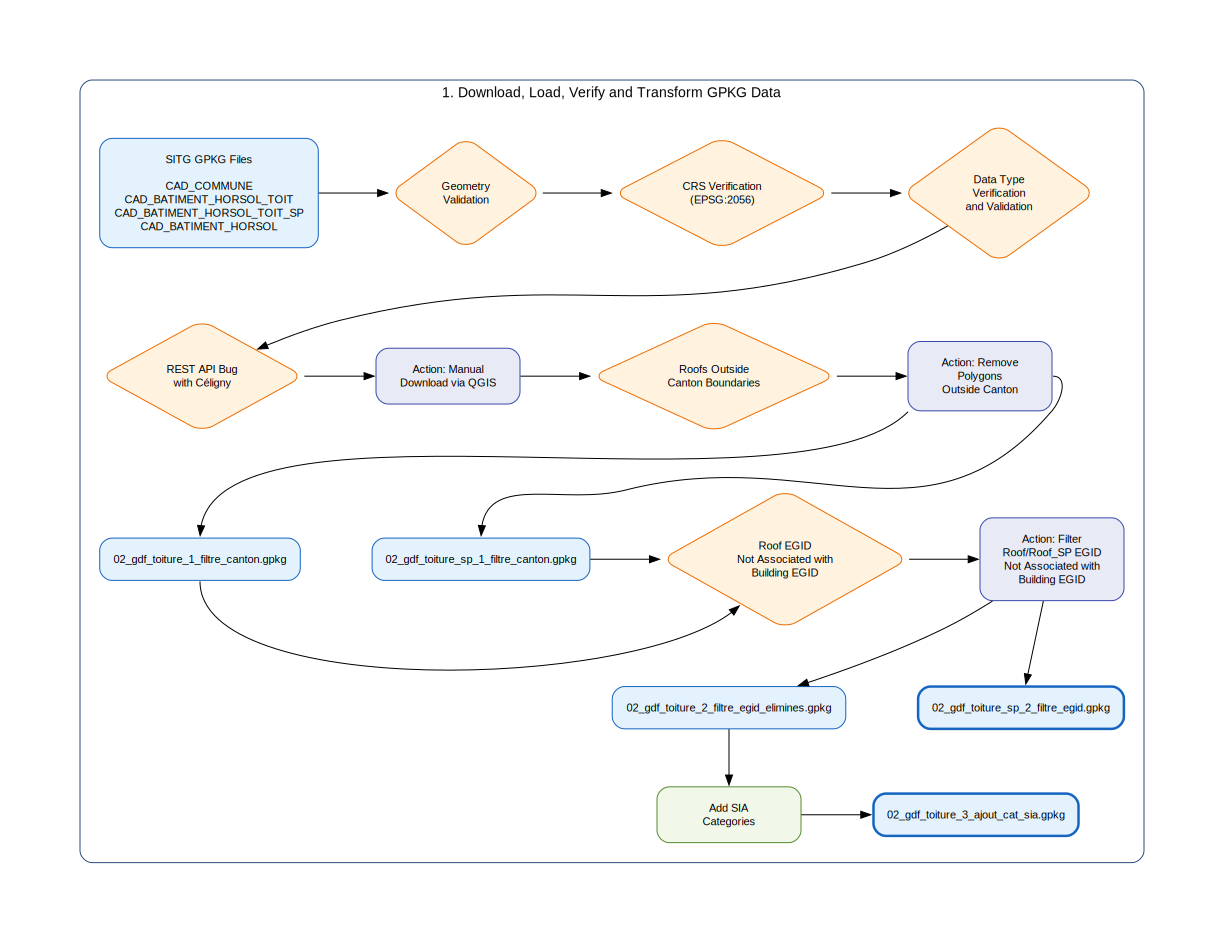

In [6]:
def create_optimized_data_flow_diagram():
    """
    Create ETL flow diagram for GPKG file processing.
    
    Generates a comprehensive flow diagram showing the data processing pipeline
    from initial file loading through validation and filtering steps.
    """
    g = Digraph("G", format="png")
    g.attr(
        rankdir="TB",
        bgcolor="transparent",
        fontname="Arial",
        pad="1.0",
        nodesep="1.0",
        ranksep="0.8",
        ratio="compress",
    )

    # Node style configuration
    g.attr(
        "node",
        shape="box",
        style="rounded,filled",
        fontname="Arial",
        fontsize="11",
        margin="0.2",
        width="2.0",
        height="0.5",
    )

    # Style definitions
    file_style = {"fillcolor": "#E3F2FD", "color": "#1565C0", "height": "0.4"}
    output_file_style = {
        "fillcolor": "#E3F2FD",
        "color": "#1565C0",
        "height": "0.4",
        "penwidth": "2.5",
        "style": "rounded,filled,bold",
    }
    process_style = {"fillcolor": "#F1F8E9", "color": "#558B2F", "height": "0.4"}
    validation_style = {"fillcolor": "#FFF3E0", "color": "#EF6C00", "shape": "diamond"}
    action_style = {"fillcolor": "#E8EAF6", "color": "#3949AB", "height": "0.4"}

    # Main cluster creation
    with g.subgraph(name="cluster_0") as c:
        c.attr(
            label="1. Download, Load, Verify and Transform GPKG Data",
            style="rounded",
            color="#2A4D7E",
            margin="20",
        )

        # Initial flow
        with c.subgraph() as s:
            s.attr(rank="source")
            s.node(
                "gpkg_files",
                "SITG GPKG Files\n\nCAD_COMMUNE\nCAD_BATIMENT_HORSOL_TOIT\nCAD_BATIMENT_HORSOL_TOIT_SP\nCAD_BATIMENT_HORSOL",
                **file_style
            )
            s.node("validate_geo", "Geometry\nValidation", **validation_style)
            s.node("check_crs", "CRS Verification\n(EPSG:2056)", **validation_style)
            s.node("check_dtypes", "Data Type\nVerification\nand Validation", **validation_style)

        # Sequential processing steps
        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("celigny", "REST API Bug\nwith Céligny", **validation_style)
            s.node("action_qgis", "Action: Manual\nDownload via QGIS", **action_style)
            s.node("batiments_hc", "Roofs Outside\nCanton Boundaries", **validation_style)
            s.node("action_remove_hc", "Action: Remove\nPolygons\nOutside Canton", **action_style)

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("gpkg_files_01", "02_gdf_toiture_1_filtre_canton.gpkg", **file_style)
            s.node(
                "gpkg_files_sp_01",
                "02_gdf_toiture_sp_1_filtre_canton.gpkg",
                **file_style
            )
            s.node(
                "egid",
                "Roof EGID\nNot Associated with\nBuilding EGID",
                **validation_style
            )
            s.node(
                "action_egid",
                "Action: Filter\nRoof/Roof_SP EGID\nNot Associated with\nBuilding EGID",
                **action_style
            )

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node(
                "gpkg_files_02",
                "02_gdf_toiture_2_filtre_egid_elimines.gpkg",
                **file_style
            )
            s.node(
                "gpkg_files_sp_02",
                "02_gdf_toiture_sp_2_filtre_egid.gpkg",
                **output_file_style
            )
        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("sia_cat", "Add SIA\nCategories", **process_style)
            s.node(
                "gpkg_files_03",
                "02_gdf_toiture_3_ajout_cat_sia.gpkg",
                **output_file_style
            )

    # Add connections
    g.edge("gpkg_files", "validate_geo")
    g.edge("validate_geo", "check_crs")
    g.edge("check_crs", "check_dtypes")
    g.edge("check_dtypes", "celigny")
    g.edge("celigny", "action_qgis")
    g.edge("action_qgis", "batiments_hc")
    g.edge("batiments_hc", "action_remove_hc")
    g.edge(
        "action_remove_hc",
        "gpkg_files_sp_01",
        constraint="true",
        tailport="e",
        headport="n",
    )
    g.edge("action_remove_hc", "gpkg_files_01", constraint="true", tailport="sw", headport="n")
    g.edge("gpkg_files_01", "egid", constraint="true", tailport="s", headport="sw")
    g.edge("gpkg_files_sp_01", "egid")
    g.edge("egid", "action_egid")
    g.edge("action_egid", "gpkg_files_02")
    g.edge("action_egid", "gpkg_files_sp_02")
    g.edge("gpkg_files_02", "sia_cat")
    g.edge("sia_cat", "gpkg_files_03")

    return g

# Generate and save diagram
g = create_optimized_data_flow_diagram()
save_high_quality_graph(
    g, f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_01_ETL_GPKG", scale_factor=4
)
g

High-quality PNG saved (4037x6995 pixels)


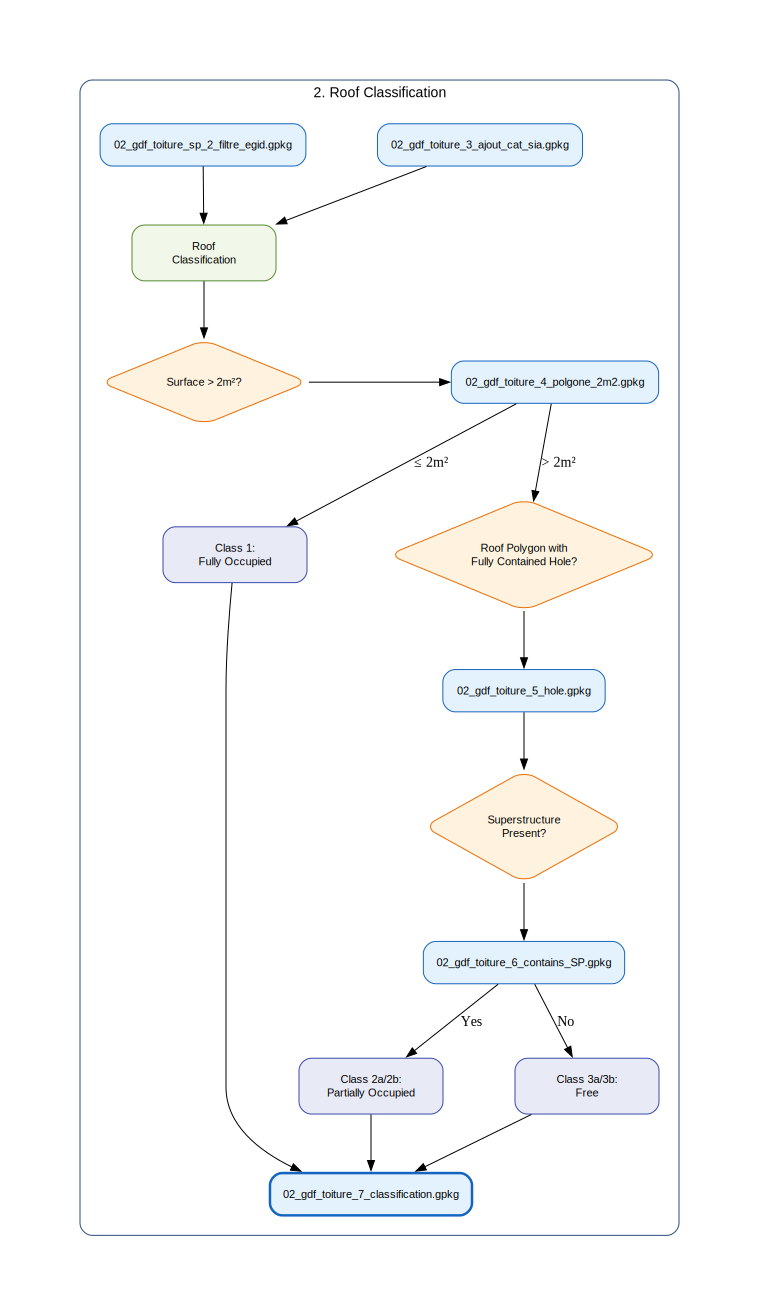

In [7]:
def create_optimized_data_flow_diagram():
    """
    Create flow diagram for roof classification process.
    
    Visualizes the classification decision tree for categorizing roofs
    based on surface area, holes, and superstructure presence.
    """
    g = Digraph("G", format="png")
    g.attr(
        rankdir="TB",
        bgcolor="transparent",
        fontname="Arial",
        pad="1.0",
        nodesep="1.0",
        ranksep="0.8",
        ratio="compress",
    )

    # Style configuration
    g.attr(
        "node",
        shape="box",
        style="rounded,filled",
        fontname="Arial",
        fontsize="11",
        margin="0.2",
        width="2.0",
        height="0.5",
    )

    # Style definitions
    file_style = {"fillcolor": "#E3F2FD", "color": "#1565C0", "height": "0.4"}
    output_file_style = {
        "fillcolor": "#E3F2FD",
        "color": "#1565C0",
        "height": "0.4",
        "penwidth": "2.5",
        "style": "rounded,filled,bold",
    }
    process_style = {"fillcolor": "#F1F8E9", "color": "#558B2F", "height": "0.4"}
    validation_style = {"fillcolor": "#FFF3E0", "color": "#EF6C00", "shape": "diamond"}
    action_style = {"fillcolor": "#E8EAF6", "color": "#3949AB", "height": "0.4"}

    # Classification cluster creation
    with g.subgraph(name="cluster_1") as c:
        c.attr(
            label="2. Roof Classification",
            style="rounded",
            color="#2A4D7E",
            margin="20",
        )

        # Node organization by levels
        with c.subgraph() as s:
            s.attr(rank="source")
            s.node(
                "gpkg_files_sp_02", "02_gdf_toiture_sp_2_filtre_egid.gpkg", **file_style
            )
            s.node("gpkg_files_03", "02_gdf_toiture_3_ajout_cat_sia.gpkg", **file_style)

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("classify_start", "Roof\nClassification", **process_style)

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("surface_check", "Surface > 2m²?", **validation_style)
            s.node("gpkg_files_04", "02_gdf_toiture_4_polgone_2m2.gpkg", **file_style)

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("classe1", "Class 1:\nFully Occupied", **action_style)
            s.node(
                "trou_check",
                "Roof Polygon with\nFully Contained Hole?",
                **validation_style
            )

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("gpkg_files_05", "02_gdf_toiture_5_hole.gpkg", **file_style)

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("sp_check", "Superstructure\nPresent?", **validation_style)

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("gpkg_files_06", "02_gdf_toiture_6_contains_SP.gpkg", **file_style)

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("classe2", "Class 2a/2b:\nPartially Occupied", **action_style)
            s.node("classe3", "Class 3a/3b:\nFree", **action_style)

        with c.subgraph() as s:
            s.attr(rank="sink")
            s.node(
                "gpkg_files_07",
                "02_gdf_toiture_7_classification.gpkg",
                **output_file_style
            )

    # Add connections
    g.edge("gpkg_files_sp_02", "classify_start")
    g.edge("gpkg_files_03", "classify_start")
    g.edge("classify_start", "surface_check")
    g.edge("surface_check", "gpkg_files_04")
    g.edge("gpkg_files_04", "classe1", "≤ 2m²")
    g.edge("gpkg_files_04", "trou_check", "> 2m²")
    g.edge("trou_check", "gpkg_files_05")
    g.edge("gpkg_files_05", "sp_check")
    g.edge("sp_check", "gpkg_files_06")
    g.edge("gpkg_files_06", "classe2", "Yes")
    g.edge("gpkg_files_06", "classe3", "No")
    g.edge("classe1", "gpkg_files_07")
    g.edge("classe2", "gpkg_files_07")
    g.edge("classe3", "gpkg_files_07")

    return g

# Generate and save
g = create_optimized_data_flow_diagram()
save_high_quality_graph(
    g, f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_02_classification", scale_factor=4
)
g

In [8]:
def create_optimized_data_flow_diagram():
    """
    Create detailed diagram of final classification logic.
    
    Shows the complete decision tree including all subclasses (2a, 2b, 3a, 3b)
    and their specific criteria for classification.
    """
    g = Digraph("G", format="png")
    g.attr(
        rankdir="TB",
        bgcolor="transparent",
        fontname="Arial",
        pad="1.0",
        nodesep="1.0",
        ranksep="0.8",
        ratio="compress",
    )

    # Style configuration
    g.attr(
        "node",
        shape="box",
        style="rounded,filled",
        fontname="Arial",
        fontsize="11",
        margin="0.2",
        width="2.0",
        height="0.5",
    )

    # Style definitions
    file_style = {"fillcolor": "#E3F2FD", "color": "#1565C0", "height": "0.4"}
    output_file_style = {
        "fillcolor": "#E3F2FD",
        "color": "#1565C0",
        "height": "0.4",
        "penwidth": "2.5",
        "style": "rounded,filled,bold",
    }
    process_style = {"fillcolor": "#F1F8E9", "color": "#558B2F", "height": "0.4"}
    validation_style = {"fillcolor": "#FFF3E0", "color": "#EF6C00", "shape": "diamond"}
    action_style = {"fillcolor": "#E8EAF6", "color": "#3949AB", "height": "0.4"}
    action_style_2 = {"fillcolor": "#FFEBEE", "color": "#D32F2F", "height": "0.4"}

    # Cluster creation
    with g.subgraph(name="cluster_1") as c:
        c.attr(
            label="2. Roof Classification",
            style="rounded",
            color="#2A4D7E",
            margin="20",
        )

        # Hierarchical node organization
        with c.subgraph() as s:
            s.attr(rank="source")
            s.node("classify_start", "Roof\nClassification", **process_style)
            s.node("surface_check", "Surface > 2m²?", **validation_style)

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node(
                "trou_check",
                "Roof Polygon with\nFully Contained Hole?",
                **validation_style
            )

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node("sp_check_avec_trou", "Superstructure?", **validation_style)
            s.node("sp_check_sans_trou", "Superstructure?", **validation_style)

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node(
                "classe2a",
                "Class 2a\nPartially Occupied\nNo Hole\nSuperstructure",
                **action_style
            )
            s.node(
                "classe2b",
                "Class 2b:\nPartially Occupied\nHole\nSuperstructure",
                **action_style
            )
            s.node(
                "classe3a",
                "Class 3a:\nFree\nNo Hole\nNo Superstructure",
                **action_style
            )
            s.node(
                "classe3b",
                "Class 3b:\nFree\nHole\nNo Superstructure",
                **action_style
            )

        with c.subgraph() as s:
            s.attr(rank="same")
            s.node(
                "classe2a_sans_sp",
                "Image Action:\nRemove SP from Image",
                **action_style_2
            )
            s.node("classe2a_avec_sp", "No Image Action", **action_style_2)
            s.node(
                "classe3b_sans_trou",
                "Image Action:\nRemove Hole from Image",
                **action_style_2
            )
            s.node("classe3b_avec_trou", "No Image Action", **action_style_2)

        with c.subgraph() as s:
            s.attr(rank="sink")
            s.node("classe1", "Class 1:\nFully Occupied", **output_file_style)
            s.node("classe2", "Class 2:\nPartially Occupied", **output_file_style)
            s.node("classe3", "Class 3:\nFree", **output_file_style)

    # Add connections
    g.edge(
        "classify_start",
        "surface_check",
        constraint="true",
        tailport="e",
        headport="w",
    )
    g.edge("surface_check", "classe1", " ≤ 2m²")
    g.edge("surface_check", "trou_check", " > 2m²")
    g.edge("trou_check", "sp_check_sans_trou", " No")
    g.edge("trou_check", "sp_check_avec_trou", " Yes")
    g.edge("sp_check_avec_trou", "classe2b", " Yes")
    g.edge("sp_check_avec_trou", "classe3b", " No")
    g.edge("sp_check_sans_trou", "classe2a", " Yes")
    g.edge("sp_check_sans_trou", "classe3a", " No")
    g.edge("classe2a", "classe2a_sans_sp")
    g.edge("classe2a", "classe2a_avec_sp")
    g.edge("classe3b", "classe3b_sans_trou")
    g.edge("classe3b", "classe3b_avec_trou")
    g.edge("classe2a_sans_sp", "classe3")
    g.edge("classe2a_avec_sp", "classe2")
    g.edge("classe3b_sans_trou", "classe3")
    g.edge("classe3b_avec_trou", "classe2")
    g.edge("classe3a", "classe3")
    g.edge("classe2b", "classe2")

    return g

# Generate and save
g = create_optimized_data_flow_diagram()
save_high_quality_graph(
    g, f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_02a_classification_finale", scale_factor=4
)

High-quality PNG saved (6511x5532 pixels)


## Data Preparation
### Loading Geospatial Data

In [9]:
def load_and_prepare_geodata(filepath, layer_name=None):
    """
    Load and prepare geospatial data with validation.
    
    Reads GPKG files, validates geometries, and optimizes memory usage
    by converting appropriate columns to categorical data types.
    
    Parameters:
        filepath (str): Path to the data file
        layer_name (str, optional): Layer name for multi-layer sources
        
    Returns:
        GeoDataFrame: Cleaned and validated data
    """
    print(f"\nLoading: {filepath}")
    
    try:
        # Read file
        if layer_name:
            gdf = gpd.read_file(filepath, layer=layer_name)
        else:
            gdf = gpd.read_file(filepath)
            
        initial_count = len(gdf)
        print(f"Initial entity count: {initial_count}")
        
        # Cleaning and validation
        # Validate geometries
        gdf['geometry'] = gdf['geometry'].make_valid()
        
        # Remove empty geometries
        gdf = gdf[~gdf['geometry'].is_empty]
        
        # Reset index
        gdf = gdf.reset_index(drop=True)
        
        # CRS verification
        if gdf.crs is None:
            print("Warning: No CRS found in data")
        else:
            print(f"CRS: {gdf.crs}")
        
        # Geometry information
        print("Geometry types:", gdf.geometry.geom_type.unique())
        print(f"Valid entity count: {len(gdf)}")
        
        if len(gdf) != initial_count:
            print(f"{initial_count - len(gdf)} invalid/empty entities removed")
        
        # Check for mixed geometry types
        geom_types = gdf.geometry.geom_type.unique()
        if len(geom_types) > 1:
            print(f"Warning: Mixed geometry types detected: {geom_types}")
        
        # Memory optimization - convert to categories
        for col in gdf.select_dtypes(include=['object']).columns:
            if col != 'geometry' and gdf[col].nunique() < len(gdf) * 0.5:
                gdf[col] = gdf[col].astype('category')
        
        return gdf
    
    except Exception as e:
        print(f"Error loading {filepath}: {str(e)}")
        raise

# Suppress non-critical warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

print("Loading datasets...")

gdf_toiture = load_and_prepare_geodata(CAD_BATIMENT_HORSOL_TOIT_GPKG_PATH)
gdf_toiture_sp = load_and_prepare_geodata(CAD_BATIMENT_HORSOL_TOIT_SP_GPKG_PATH)
gdf_cad_batiment_horsol = load_and_prepare_geodata(CAD_BATIMENT_HORSOL_GPKG_PATH)
gdf_cad_commune = load_and_prepare_geodata(CAD_COMMUNE_GPKG_PATH)

# CRS consistency verification
crs_list = [
    gdf_toiture.crs,
    gdf_toiture_sp.crs,
    gdf_cad_batiment_horsol.crs,
    gdf_cad_commune.crs
]

if len(set(crs_list)) > 1:
    print("\nWarning: Different CRS detected between datasets:")
    print("gdf_toiture CRS:", gdf_toiture.crs)
    print("gdf_toiture_sp CRS:", gdf_toiture_sp.crs)
    print("gdf_cad_batiment_horsol CRS:", gdf_cad_batiment_horsol.crs)
    print("gdf_cad_commune CRS:", gdf_cad_commune.crs)

# Loading summary
print("\nData loading summary:")
print(f"gdf_toiture: {len(gdf_toiture)} entities")
print(f"gdf_toiture_sp: {len(gdf_toiture_sp)} entities")
print(f"gdf_cad_batiment_horsol: {len(gdf_cad_batiment_horsol)} entities")
print(f"gdf_cad_commune: {len(gdf_cad_commune)} entities")


Loading datasets...

Loading: data/SITG/CAD_BATIMENT_HORSOL_TOIT_2024-11-03.gpkg
Initial entity count: 335730
CRS: EPSG:2056
Geometry types: ['MultiPolygon' 'Polygon']
Valid entity count: 335729
1 invalid/empty entities removed

Loading: data/SITG/CAD_BATIMENT_HORSOL_TOIT_SP_2024-11-03.gpkg
Initial entity count: 122126
CRS: EPSG:2056
Geometry types: ['MultiPolygon']
Valid entity count: 122126

Loading: data/SITG/CAD_BATIMENT_HORSOL_2024-11-03.gpkg
Initial entity count: 82502
CRS: EPSG:2056
Geometry types: ['MultiPolygon' 'Polygon']
Valid entity count: 82502

Loading: data/SITG/CAD_COMMUNE_2024-11-03.gpkg
Initial entity count: 48
CRS: EPSG:2056
Geometry types: ['MultiPolygon']
Valid entity count: 48

Data loading summary:
gdf_toiture: 335729 entities
gdf_toiture_sp: 122126 entities
gdf_cad_batiment_horsol: 82502 entities
gdf_cad_commune: 48 entities


### Data Type Correction

In [10]:
# Convert dates from millisecond timestamps
gdf_toiture["date_leve"] = pd.to_datetime(gdf_toiture["date_leve"], unit="ms")
gdf_toiture_sp["date_leve"] = pd.to_datetime(gdf_toiture_sp["date_leve"], unit="ms")

# Clean global identifiers (remove braces)
gdf_toiture["globalid"] = (
    gdf_toiture["globalid"].str.replace("{", "").str.replace("}", "")
)
gdf_toiture_sp["globalid"] = (
    gdf_toiture_sp["globalid"].str.replace("{", "").str.replace("}", "")
)
gdf_cad_batiment_horsol["globalid"] = (
    gdf_cad_batiment_horsol["globalid"].str.replace("{", "").str.replace("}", "")
)
gdf_cad_commune["globalid"] = (
    gdf_cad_commune["globalid"].str.replace("{", "").str.replace("}", "")
)

# Display samples and data types
display(gdf_toiture.head(2))
display(gdf_toiture.dtypes)
display(gdf_toiture_sp.head(2))
display(gdf_toiture_sp.dtypes)
display(gdf_cad_batiment_horsol.head(2))
display(gdf_cad_batiment_horsol.dtypes)
display(gdf_cad_commune.head(2))
display(gdf_cad_commune.dtypes)

,objectid,egid,altitude_min,altitude_max,date_leve,SHAPE__Length,SHAPE__Area,globalid,geometry
0,1,295515551.0,402.53,403.99,2016-03-01 01:00:00,15.955607,15.878718,06AFF1FA-97BC-4F46-9D82-533737CEFD32,"MULTIPOLYGON (((2499719.326 1123293.907, 24997..."
1,2,295157782.0,400.85,400.85,2016-03-01 01:00:00,9.413241,5.404905,49817796-536A-43BB-A09D-B29096D4E0CE,"MULTIPOLYGON (((2499829.364 1122862.481, 24998..."


objectid                  int64
egid                    float64
altitude_min            float64
altitude_max            float64
date_leve        datetime64[ms]
SHAPE__Length           float64
SHAPE__Area             float64
globalid                 object
geometry               geometry
dtype: object

,objectid,egid,altitude_min,altitude_max,date_leve,SHAPE__Length,SHAPE__Area,globalid,geometry
0,1,295157782.0,404.01,404.64,2016-03-01 01:00:00,9.746051,3.592775,66C1190B-2192-42C1-82F8-24E1A2767BE2,"MULTIPOLYGON (((2499824.511 1122866.114, 24998..."
1,2,295171234.0,414.34,415.12,2016-03-01 01:00:00,9.997309,3.183067,A75168A6-FA50-4882-BCF5-78F06FB425E2,"MULTIPOLYGON (((2499860.441 1122743.205, 24998..."


objectid                  int64
egid                    float64
altitude_min            float64
altitude_max            float64
date_leve        datetime64[ms]
SHAPE__Length           float64
SHAPE__Area             float64
globalid                 object
geometry               geometry
dtype: object

,objectid,commune,no_comm,no_batiment,ident,egid,nombat,mutnum,datedt,destination,...,niveaux_horsol,niveaux_ssol,hauteur,surface,egrid_liste,egrid_centroide,globalid,st_area(shape),st_length(shape),geometry
0,1,Genève-Cité,21,F435,21:F435,295085809,NaN,1261951,2006-01-20 18:30:57,Garage privé,...,NaN,NaN,2.19,1165,CH116358658204,CH116358658204,B666F465-386D-46DE-B344-AE7E743D20DD,1164.901234,160.088708,"MULTIPOLYGON (((2499345.413 1118016.561, 24993..."
1,2,Genève-Cité,21,D105,21:D105,295100289,NaN,1021985,2006-01-20 18:30:57,Hangar,...,NaN,NaN,10.14,1086,CH716314658497,CH716314658497,A74377F9-79D2-408E-9F28-4E1774D3B33C,1085.655776,171.522161,"MULTIPOLYGON (((2500055.956 1119090.358, 25000..."


objectid                         int64
commune                       category
no_comm                          int32
no_batiment                   category
ident                           object
egid                             int64
nombat                        category
mutnum                        category
datedt                  datetime64[ms]
destination                   category
nomenclature                  category
nomen_classe                  category
provenance                    category
no_autor                      category
epoque_construction           category
annee_construction             float64
annee_transfornation           float64
niveaux_horsol                 float64
niveaux_ssol                   float64
hauteur                        float64
surface                          int64
egrid_liste                     object
egrid_centroide                 object
globalid                        object
st_area(shape)                 float64
st_length(shape)         

,objectid,commune,no_comm,abreviation,no_com_federal,lien_www,globalid,st_area(shape),st_length(shape),geometry
0,1,Meinier,32,Mr,6629,https://www.acg.ch/?q=node/158,A6CEBC20-4ADC-4373-851B-8F239EA8CD96,6.953481e+06,15469.467885,"MULTIPOLYGON (((2508022.376 1120164.941, 25080..."
1,2,Avusy,4,As,6604,https://www.acg.ch/?q=node/158,DC3EDA72-F903-419C-B3AD-424C0703EAEC,5.172039e+06,12501.149830,"MULTIPOLYGON (((2487481.864 1111135.717, 24874..."


objectid               int64
commune               object
no_comm                int32
abreviation           object
no_com_federal         int32
lien_www            category
globalid              object
st_area(shape)       float64
st_length(shape)     float64
geometry            geometry
dtype: object

### Geometry Validation

=== Commune Data Verification ===

Total communes: 48

Geometry types present:
MultiPolygon    48
Name: count, dtype: int64

Céligny verification:
Records for Céligny: 1
Geometry type for Céligny: ['MultiPolygon']
Céligny bounds: [2502086.49000663 1131720.61404387 2507832.82296602 1135578.42990992]


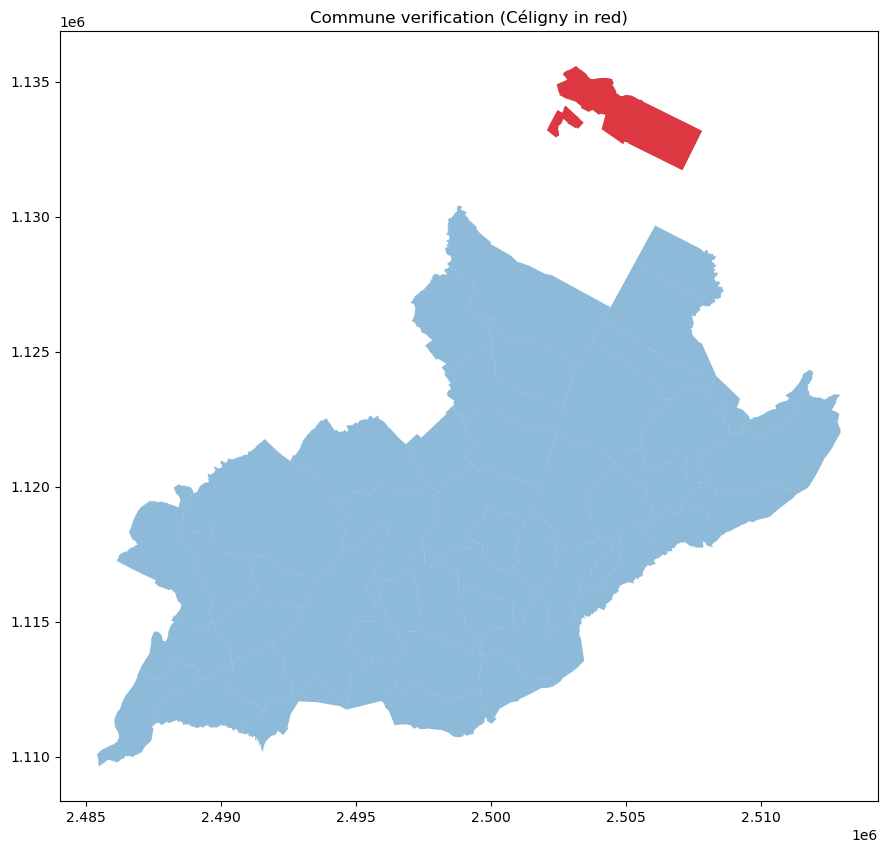

In [11]:
def verify_commune_data(gdf):
    """
    Verify commune data integrity with focus on Céligny.
    
    Checks for data completeness and visualizes commune boundaries
    with special attention to potential data issues.
    """
    print("=== Commune Data Verification ===")
    print(f"\nTotal communes: {len(gdf)}")
    print("\nGeometry types present:")
    print(gdf.geometry.type.value_counts())

    print("\nCéligny verification:")
    celigny = gdf[gdf["commune"] == "Céligny"]
    print(f"Records for Céligny: {len(celigny)}")
    if len(celigny) > 0:
        print("Geometry type for Céligny:", celigny.geometry.type.values)
        print("Céligny bounds:", celigny.total_bounds)

    # Visualization
    fig, ax = plt.subplots(figsize=(15, 10))
    gdf.plot(ax=ax, alpha=0.5)
    if len(celigny) > 0:
        celigny.plot(ax=ax, color="red", alpha=0.7)
    plt.title("Commune verification (Céligny in red)")
    plt.show()

    return celigny

celigny = verify_commune_data(gdf_cad_commune)

In [12]:
# CRS verification
print("Layer CRS:")
print(f"gdf_toiture CRS: {gdf_toiture.crs}")
print(f"gdf_toiture_sp CRS: {gdf_toiture_sp.crs}")
print(f"gdf_cad_commune CRS: {gdf_cad_commune.crs}")
print(f"gdf_cad_batiment_horsol CRS: {gdf_cad_batiment_horsol.crs}")

# Geometry validity check
print("\nGeometry validity:")
print(f"Invalid geometries in gdf_toiture: {sum(~gdf_toiture.is_valid)}")
print(f"Invalid geometries in gdf_toiture_sp: {sum(~gdf_toiture_sp.is_valid)}")
print(f"Invalid geometries in gdf_cad_commune: {sum(~gdf_cad_commune.is_valid)}")
print(
    f"Invalid geometries in gdf_cad_batiment_horsol: {sum(~gdf_cad_batiment_horsol.is_valid)}"
)

print("\nInvalid geometries after correction:")
print(f"Invalid geometries in gdf_toiture: {sum(~gdf_toiture.is_valid)}")
print(f"Invalid geometries in gdf_toiture_sp: {sum(~gdf_toiture_sp.is_valid)}")
print(f"Invalid geometries in gdf_cad_commune: {sum(~gdf_cad_commune.is_valid)}")
print(
    f"Invalid geometries in gdf_cad_batiment_horsol: {sum(~gdf_cad_batiment_horsol.is_valid)}"
)

Layer CRS:
gdf_toiture CRS: EPSG:2056
gdf_toiture_sp CRS: EPSG:2056
gdf_cad_commune CRS: EPSG:2056
gdf_cad_batiment_horsol CRS: EPSG:2056

Geometry validity:
Invalid geometries in gdf_toiture: 0
Invalid geometries in gdf_toiture_sp: 0
Invalid geometries in gdf_cad_commune: 0
Invalid geometries in gdf_cad_batiment_horsol: 0

Invalid geometries after correction:
Invalid geometries in gdf_toiture: 0
Invalid geometries in gdf_toiture_sp: 0
Invalid geometries in gdf_cad_commune: 0
Invalid geometries in gdf_cad_batiment_horsol: 0


### Filtrage des polygones hors canton

In [13]:
def fast_spatial_filter(gdf_toiture, gdf_cad_commune):
    """
    Optimized spatial filtering of roof polygons using prepared geometry
    and spatial index.
    
    Efficiently filters roof polygons to keep only those within canton boundaries
    using spatial indexing and prepared geometry for performance.

    Parameters:
        gdf_toiture (GeoDataFrame): Roof polygons
        gdf_cad_commune (GeoDataFrame): Cadastral commune boundaries

    Returns:
        tuple: (filtered_gdf, excluded_gdf)
    """
    # Create single polygon from commune boundaries
    if len(gdf_cad_commune) > 1:
        boundary = gdf_cad_commune.geometry.union_all()
    else:
        boundary = gdf_cad_commune.geometry.iloc[0]

    # Prepared geometry for faster operations
    prepared_boundary = prep(boundary)

    # Use spatial index
    spatial_index = gdf_toiture.sindex

    # Potential candidates via spatial index
    possible_matches_index = list(spatial_index.intersection(boundary.bounds))
    possible_matches = gdf_toiture.iloc[possible_matches_index]

    # Final filtering with prepared geometry
    mask = possible_matches.geometry.apply(lambda x: prepared_boundary.intersects(x))
    filtered = possible_matches[mask]

    # Excluded geometries
    excluded = gdf_toiture[~gdf_toiture.index.isin(filtered.index)]

    return filtered, excluded

# Filter gdf_toiture
gdf_toiture_1_filtre_canton, gdf_toiture_1_filtre_canton_elimines = fast_spatial_filter(gdf_toiture, gdf_cad_commune)
print(
    f"Polygons outside canton in gdf_toiture: {len(gdf_toiture_1_filtre_canton_elimines)}"
)

# Filter gdf_toiture_sp
gdf_toiture_sp_1_filtre_canton, gdf_toiture_sp_1_filtre_canton_elimines = fast_spatial_filter(gdf_toiture_sp, gdf_cad_commune)
print(
    f"Polygons outside canton in gdf_toiture_sp: {len(gdf_toiture_sp_1_filtre_canton_elimines)}"
)


Polygons outside canton in gdf_toiture: 1436
Polygons outside canton in gdf_toiture_sp: 582


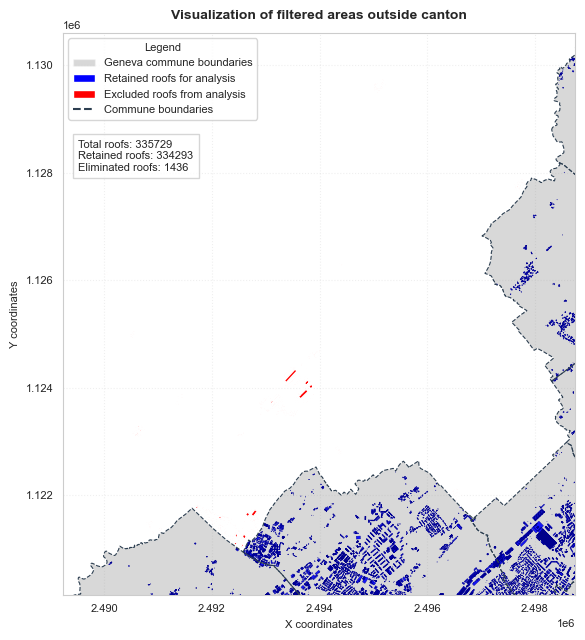

In [14]:
def visualize_problem_area1(
    gdf_toiture,
    gdf_cad_commune,
    gdf_toiture_1_filtre_canton,
    eliminated_polys,
    gdf_name,
):
    """
    Visualize filtered areas with focus on eliminated polygons.
    
    Creates a detailed visualization showing retained vs excluded polygons
    with appropriate zoom and statistics.
    """
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(6.5, 6.5))

    plt.title(
        "Visualization of filtered areas outside canton",
        pad=10,
        fontsize=10,
        fontweight="bold",
    )

    # Legend element creation
    legend_elements = []

    # Plot layers
    # Communes
    commune_plot = gdf_cad_commune.plot(
        ax=ax,
        color="grey",
        alpha=0.3,
        label="Commune boundaries",
        zorder=1,
    )
    legend_elements.append(
        Patch(facecolor="grey", alpha=0.3, label="Geneva commune boundaries")
    )

    # Retained roofs
    retained_plot = gdf_toiture_1_filtre_canton.plot(
        ax=ax,
        color="blue",
        edgecolor="darkblue",
        linewidth=0.3,
        alpha=0.9,
        label="Retained roofs for analysis",
        zorder=4,
    )
    legend_elements.append(
        Patch(facecolor="blue", alpha=1, label="Retained roofs for analysis")
    )

    # Eliminated roofs
    eliminated_plot = eliminated_polys.plot(
        ax=ax,
        color="red",
        alpha=1,
        label="Excluded roofs from analysis",
        zorder=3,
    )
    legend_elements.append(
        Patch(facecolor="red", alpha=1, label="Excluded roofs from analysis")
    )

    # Commune boundaries
    boundary_plot = gdf_cad_commune.boundary.plot(
        ax=ax,
        color="#2C3E50",
        linewidth=0.8,
        linestyle="--",
        zorder=4,
    )
    legend_elements.append(
        Line2D([0], [0], color="#2C3E50", linestyle="--", label="Commune boundaries")
    )

    # Legend
    ax.legend(
        handles=legend_elements,
        title="Legend",
        title_fontsize=8,
        fontsize=8,
        loc="upper left",
        facecolor="white",
        edgecolor="#CCCCCC",
    )

    # Axis configuration
    ax.grid(True, linestyle=":", alpha=0.3)
    ax.set_xlabel("X coordinates", fontsize=8)
    ax.set_ylabel("Y coordinates", fontsize=8)
    plt.tick_params(axis='both', labelsize=8)
    ax.xaxis.get_offset_text().set_fontsize(8)
    ax.yaxis.get_offset_text().set_fontsize(8)

    # Zoom on eliminated roofs
    if not eliminated_polys.empty:
        bounds = eliminated_polys.total_bounds
        margin = 100
        x_min, y_min, x_max, y_max = bounds
        width = x_max - x_min
        height = y_max - y_min
        margin_x = width * 0.1
        margin_y = height * 0.1
        ax.set_xlim(x_min - margin_x, x_max + margin_x)
        ax.set_ylim(y_min - margin_y, y_max + margin_y)
    else:
        plt.text(
            0.5,
            0.5,
            "No eliminated roofs",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            fontsize=8,
        )

    plt.tight_layout()

    # Statistics
    stats_text = (
        f"Total roofs: {len(gdf_toiture)}\n"
        f"Retained roofs: {len(gdf_toiture_1_filtre_canton)}\n"
        f"Eliminated roofs: {len(eliminated_polys)}"
    )
    plt.figtext(
        0.152,
        0.752,
        stats_text,
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="#CCCCCC"),
        horizontalalignment="left",
        verticalalignment="center",
    )

    # Save
    output_file = f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_01_visu_zone_hors_canton.png"
    plt.savefig(output_file, bbox_inches="tight", dpi=300)

    plt.show()

plt.close()
# Visualization
visualize_problem_area1(
    gdf_toiture,
    gdf_cad_commune,
    gdf_toiture_1_filtre_canton,
    gdf_toiture_1_filtre_canton_elimines,
    "CAD_BATIMENT_HORSOL_TOIT",
)

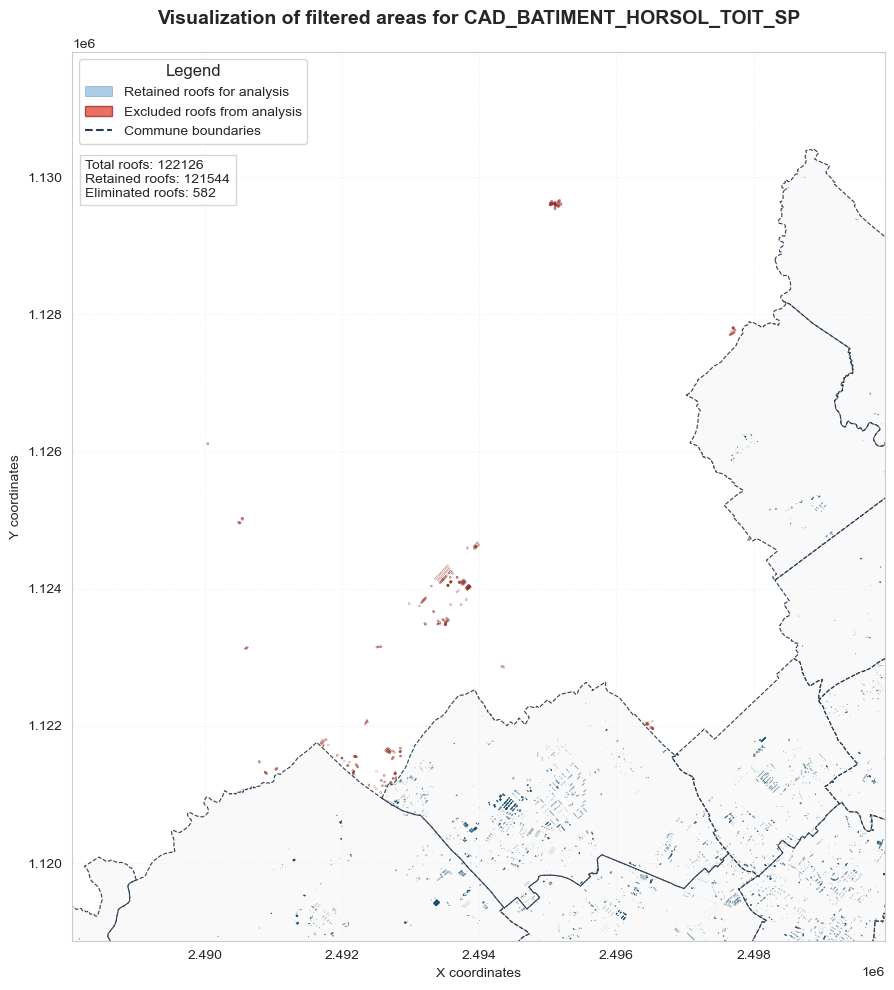

In [15]:
def visualize_problem_area2(
    gdf_toiture,
    gdf_cad_commune,
    gdf_toiture_1_filtre_canton,
    eliminated_polys,
    gdf_name,
):
    """
    Visualize filtered areas with detailed view.
    
    Provides an alternative visualization focusing on the spatial relationship
    between retained and excluded polygons.
    """
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(10,10))

    plt.title(
        f"Visualization of filtered areas for {gdf_name}",
        pad=20,
        fontsize=14,
        fontweight="bold",
    )

    # Background map (communes)
    gdf_cad_commune.plot(
        ax=ax,
        color="#EEEEEE",
        alpha=0.3,
    )

    # Retained roofs (lower layer)
    if not gdf_toiture_1_filtre_canton.empty:
        gdf_toiture_1_filtre_canton.plot(
            ax=ax,
            color="#2E86C1",
            alpha=0.4,
            linewidth=0.5,
            edgecolor="#1B4F72",
        )

    # Eliminated roofs (upper layer)
    eliminated_polys.plot(
        ax=ax,
        color="#E74C3C",
        alpha=0.8,
        linewidth=1.5,
        edgecolor="#943126",
    )

    # Commune boundaries
    gdf_cad_commune.boundary.plot(
        ax=ax,
        color="#2C3E50",
        linewidth=0.8,
        linestyle="--",
    )

    # Legend
    legend_elements = [
        Patch(
            facecolor="#2E86C1",
            alpha=0.4,
            edgecolor="#1B4F72",
            linewidth=0.5,
            label="Retained roofs for analysis",
        ),
        Patch(
            facecolor="#E74C3C",
            alpha=0.8,
            edgecolor="#943126",
            linewidth=1,
            label="Excluded roofs from analysis",
        ),
        Line2D([0], [0], color="#2C3E50", linestyle="--", label="Commune boundaries"),
    ]

    ax.legend(
        handles=legend_elements,
        title="Legend",
        title_fontsize=12,
        fontsize=10,
        loc="upper left",
        facecolor="white",
        edgecolor="#CCCCCC",
    )

    # Axis configuration
    ax.grid(True, linestyle=":", alpha=0.3)
    ax.set_xlabel("X coordinates", fontsize=10)
    ax.set_ylabel("Y coordinates", fontsize=10)

    # Visualization area based on eliminated roofs
    if not eliminated_polys.empty:
        bounds = eliminated_polys.total_bounds
        x_min, y_min, x_max, y_max = bounds
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        margin_factor = 0.5
        zoom_width = width * (1 + margin_factor)
        zoom_height = height * (1 + margin_factor)
        ax.set_xlim(center_x - zoom_width / 2, center_x + zoom_width / 2)
        ax.set_ylim(center_y - zoom_height / 2, center_y + zoom_height / 2)

    plt.tight_layout()

    # Statistics
    stats_text = (
        f"Total roofs: {len(gdf_toiture)}\n"
        f"Retained roofs: {len(gdf_toiture_1_filtre_canton)}\n"
        f"Eliminated roofs: {len(eliminated_polys)}"
    )
    plt.figtext(
        0.12,
        0.815,
        stats_text,
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="#CCCCCC"),
        horizontalalignment="left",
        verticalalignment="center",
    )

    plt.show()

try:
    visualize_problem_area2(
        gdf_toiture_sp,
        gdf_cad_commune,
        gdf_toiture_sp_1_filtre_canton,
        gdf_toiture_sp_1_filtre_canton_elimines,
        "CAD_BATIMENT_HORSOL_TOIT_SP",
    )
except Exception as e:
    print(f"Visualization error: {e}")

In [16]:
# Save results to Parquet
gdf_toiture_1_filtre_canton.to_parquet(
    f"{OUTPUT_PARQUET_NOTEBOOK_02_PATH}/02_gdf_toiture_1_filtre_canton.parquet"
)
gdf_toiture_sp_1_filtre_canton.to_parquet(
    f"{OUTPUT_PARQUET_NOTEBOOK_02_PATH}/02_gdf_toiture_sp_1_filtre_canton.parquet"
)

### EGID Validation Filtering

In [17]:
# Identify invalid EGIDs (below building minimum)
egid_bizarre = gdf_cad_batiment_horsol["egid"].min()
print("Minimum EGID in gdf_cad_batiment_horsol:", egid_bizarre)
print("Roofs with invalid EGID:")
print(f"\t{gdf_toiture_1_filtre_canton[gdf_toiture_1_filtre_canton['egid'] < egid_bizarre].shape[0]} \
in gdf_toiture_1_filtre_canton")
print(f"\t{gdf_toiture_sp_1_filtre_canton[gdf_toiture_sp_1_filtre_canton['egid'] < egid_bizarre].shape[0]} \
in gdf_toiture_sp_1_filtre_canton")
print(f"\t{gdf_cad_batiment_horsol[gdf_cad_batiment_horsol['egid'] < egid_bizarre].shape[0]} \
in gdf_cad_batiment_horsol")

filtre_egid_toiture = gdf_toiture_1_filtre_canton[
    gdf_toiture_1_filtre_canton["egid"] < egid_bizarre
]

Minimum EGID in gdf_cad_batiment_horsol: 295074
Roofs with invalid EGID:
	22 in gdf_toiture_1_filtre_canton
	2 in gdf_toiture_sp_1_filtre_canton
	0 in gdf_cad_batiment_horsol


In [18]:
# Apply EGID filter
gdf_toiture_2_filtre_egid = gdf_toiture_1_filtre_canton[
    gdf_toiture_1_filtre_canton["egid"] > gdf_cad_batiment_horsol["egid"].min()
]

gdf_toiture_sp_2_filtre_egid = gdf_toiture_sp_1_filtre_canton[
    gdf_toiture_sp_1_filtre_canton["egid"] > gdf_cad_batiment_horsol["egid"].min()
]

# Save results
gdf_toiture_2_filtre_egid.to_parquet(
   f"{OUTPUT_PARQUET_NOTEBOOK_02_PATH}/02_gdf_toiture_2_filtre_egid.parquet"
)
gdf_toiture_sp_2_filtre_egid.to_parquet(
   f"{OUTPUT_PARQUET_NOTEBOOK_02_PATH}/02_gdf_toiture_sp_2_filtre_egid.parquet"
)

### SIA Category Assignment

In [19]:
def assign_sia_category(destination):
    """
    Assign SIA 380/1:2009 category based on building destination.
    
    Maps building usage types to standard SIA energy categories
    for building classification purposes.
    
    Parameters:
        destination (str): Building destination
        
    Returns:
        str: SIA category (I to XII) or 'NA'
    """
    dest = str(destination).lower()

    # Category I - Collective housing
    habitat_collectif = [
        "hab plusieurs logements",
        "résidence meublée",
        "foyer",
        "hôtel",
        "autre héberg. collectif",
        "etab. pénitenciaire",
        "caserne",
        "internat",
        "hab. - rez activités",
        "habitation - activités",
    ]
    if any(term in dest for term in habitat_collectif):
        return "I habitat collectif"

    # Category II - Individual housing
    habitat_individuel = [
        "habitation un logement",
        "hab. deux logements",
        ]
    if any(term in dest for term in habitat_individuel):
        return "II habitat individuel"

    # Category III - Administration
    administration = [
        "bureaux",
        "bureaux des oig",
        "administration",
        "administrations publiques",
        "mairie",
        "poste",
        "mission permanente",
        "consulat",
        "douane",
        "police",
        "bibliothèque",
        "musée",
        "onu",
        "central de télécom.",
        "cabine t+t",
        "installation de téléphonie mobile",
        "autre équipement collectif",
    ]
    if any(term in dest for term in administration):
        return "III administration"

    # Category IV - Schools
    ecoles = [
        "école primaire",
        "ecole privée",
        "collège",
        "université",
        "jardin d'enfants",
        "conservatoire musique",
        "autre école",
        "ecole primaire",
    ]
    if any(term in dest for term in ecoles):
        return "IV écoles"

    # Category V - Commerce
    commerce = [
        "commerce",
        "centre commercial",
        "halle d'exposition",
        "port-franc"]
    if any(term in dest for term in commerce):
        return "V commerce"

    # Category VI - Restaurants
    restauration = ["restaurant", "divertissement"]
    if any(term in dest for term in restauration):
        return "VI restauration"

    # Category VII - Assembly locations
    rassemblement = [
        "temple",
        "chapelle",
        "église",
        "synagogue",
        "mosquée",
        "autre lieu de culte",
        "cinéma",
        "théâtre",
        "salle de spectacle",
        "salle communale",
        "centre de loisirs",
        "autre bât. de loisirs",
        "wc public",
        "eglise",
        "parking public",
    ]
    if any(term in dest for term in rassemblement):
        return "VII lieux de rassemblement"

    # Category VIII - Hospitals
    hopitaux = [
        "hôpital,clinique",
        "etablissement de soins",
        "hôpital, clinique",
        "ems",
    ]
    if any(term in dest for term in hopitaux):
        return "VIII hôpitaux"

    # Category IX - Industry
    industrie = [
        "usine",
        "atelier",
        "garage privé",
        "garage",
        "cern",
        "ferme",
        "voirie-entretien",
        "gare",
        "service du feu",
        "arsenal",
        "station-service",
        "station d'épuration",
        "bât. électricité sig",
        "bâtiment électricité",
        "instal. tech. élec. sig",
        "instal. tech. élec.",
        "bâtiment gaz sig",
        "bâtiment gaz",
        "instal. tech. gaz sig",
        "instal. tech.gaz",
        "bâtiment eau sig",
        "bâtiment eau",
        "instal. tech. eau sig",
        "instal. tech. eau",
        "ouvrage aéroportuaire",
        "sécurité civile",
        "dépôt tpg",
        "chantier naval",
        "autre bâtiment de prod. agricole",
        "installation de chauffage",
        "cheminée",
        "poulailler",
        "serre",
        "porcherie",
        "citerne gaz",
        "compostage",
        "chauffage à distance",
        "citerne mazout",
        "installation de climatisation",
        "réservoir",
        "ecurie",
    ]
    if any(term in dest for term in industrie):
        return "IX industrie"

    # Category X - Storage
    depots = [
        "dépôt",
        "hangar",
        "hangar agricole",
        "silo",
        "autre bât. de prod. agricole",
        "déchetterie",
        "autre bât. < 20 m2",
        "autre bât. 20m2 et plus",
        "autre bât. d'activités",
    ]
    if any(term in dest for term in depots):
        return "X dépôts"

    # Category XI - Sports facilities
    sport = [
        "salle de sport",
        "centre sportif",
        "stade",
        "stand de tir",
        "manège",
        "patinoire",
    ]
    if any(term in dest for term in sport):
        return "XI installations sportives"

    # Category XII - Indoor pools
    piscines = [
        "piscine",
    ]
    if any(term in dest for term in piscines):
        return "XII piscines couvertes"

    return "NA"

# Apply categorization
gdf_cad_batiment_horsol['sia_cat'] = gdf_cad_batiment_horsol['destination'].apply(assign_sia_category)

display(gdf_cad_batiment_horsol[gdf_cad_batiment_horsol["sia_cat"] == "NA"]["destination"].str.lower().unique())


array([], dtype=object)

In [20]:
print(gdf_cad_batiment_horsol["sia_cat"].value_counts())
print(f"Missing values in sia_cat: {gdf_cad_batiment_horsol["sia_cat"].isna().sum()}")
assert gdf_cad_batiment_horsol["sia_cat"].isna().sum() == 0

sia_cat
II habitat individuel         29420
IX industrie                  16947
X dépôts                      16575
I habitat collectif           15337
III administration             1836
IV écoles                       746
VII lieux de rassemblement      520
V commerce                      415
XI installations sportives      257
VIII hôpitaux                   233
VI restauration                 205
XII piscines couvertes           11
Name: count, dtype: int64
Missing values in sia_cat: 0



Summary table:
                  Category        Description Number Percentage
     II habitat individuel Individual housing 29'420      35.7%
              IX industrie           Industry 16'947      20.5%
                  X dépôts            Storage 16'575      20.1%
       I habitat collectif Collective housing 15'337      18.6%
        III administration     Administration  1'836       2.2%
                 IV écoles            Schools    746       0.9%
VII lieux de rassemblement Assembly locations    520       0.6%
                V commerce           Commerce    415       0.5%
XI installations sportives  Sports facilities    257       0.3%
             VIII hôpitaux          Hospitals    233       0.3%
           VI restauration        Restaurants    205       0.2%
    XII piscines couvertes       Indoor pools     11       0.0%


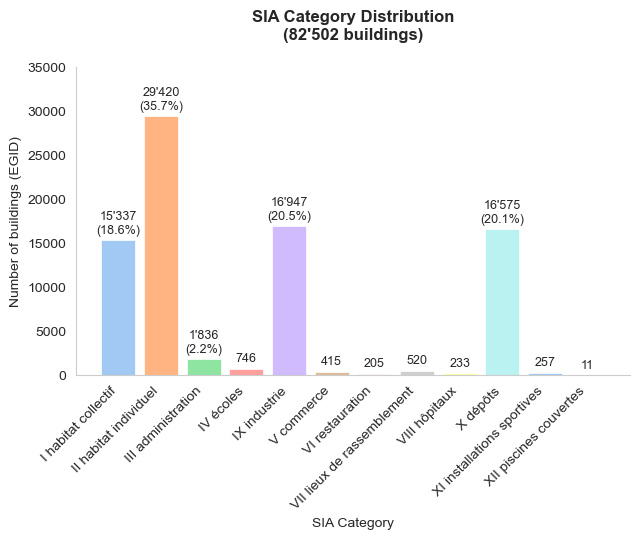

In [21]:
def format_number(num):
    """Format number with apostrophe as thousands separator."""
    return f"{num:,}".replace(",", "'")

def create_sia_categories_analysis(df, output_path=None):
    """
    Create comprehensive SIA categories analysis with visualization and statistics.

    Parameters:
        df (DataFrame): DataFrame containing SIA categories
        output_path (str, optional): Save path

    Returns:
        tuple: (figure, statistics_dataframe)
    """
    sns.set_style("whitegrid")
    
    # Category names and color palette definitions
    sia_categories = {
        "I habitat collectif": "Collective housing",
        "II habitat individuel": "Individual housing", 
        "III administration": "Administration",
        "IV écoles": "Schools",
        "V commerce": "Commerce",
        "VI restauration": "Restaurants",
        "VII lieux de rassemblement": "Assembly locations",
        "VIII hôpitaux": "Hospitals",
        "IX industrie": "Industry",
        "X dépôts": "Storage",
        "XI installations sportives": "Sports facilities",
        "XII piscines couvertes": "Indoor pools",
    }

    # Pastel color palette
    pastel_colors = sns.color_palette("pastel", len(sia_categories))
    sia_colors = dict(zip(sorted(sia_categories.keys()), pastel_colors))

    # Calculate statistics
    total = len(df)
    value_counts = df["sia_cat"].value_counts()
    percentages = (value_counts / total * 100).round(1)

    # Create figure
    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    
    # Bar chart
    ordered_categories = sorted(df["sia_cat"].unique())
    bars = ax.bar(range(len(ordered_categories)), 
                  [value_counts[cat] for cat in ordered_categories],
                  color=[sia_colors[cat] for cat in ordered_categories],
                  edgecolor='white', linewidth=0.5)

    # Title and labels configuration
    ax.set_title(f"SIA Category Distribution\n({format_number(total)} buildings)", 
                fontsize=12, fontweight='bold', pad=20)
    ax.set_xlabel("SIA Category", fontsize=10)
    ax.set_ylabel("Number of buildings (EGID)", fontsize=10)

    # Grid configuration
    ax.grid(False)
    ax.set_axisbelow(True)
    
    # X-axis configuration
    ax.set_xticks(range(len(ordered_categories)))
    ax.set_xticklabels(ordered_categories, rotation=45, ha='right', fontsize=10)

    # Add values on bars
    for i, (bar, cat) in enumerate(zip(bars, ordered_categories)):
        height = bar.get_height()
        percentage = percentages[cat]
        
        if percentage >= 1.0:
            label = f"{format_number(int(height))}\n({percentage:.1f}%)"
        else:
            label = f"{format_number(int(height))}"
            
        ax.text(bar.get_x() + bar.get_width()/2, height + total*0.005,
                label, ha='center', va='bottom', 
                fontsize=9)

    ax.set_ylim(0, 35000)

    # Remove borders
    sns.despine(ax=ax, top=True, right=True)
    ax.yaxis.grid(False)

    plt.tight_layout()
    
    # Save if path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", 
                   facecolor="white", edgecolor='none')

    # Create summary table
    summary_df = pd.DataFrame({
        "Category": value_counts.index,
        "Description": value_counts.index.map(sia_categories),
        "Number": [format_number(int(x)) for x in value_counts.values],
        "Percentage": [f"{p:.1f}%" for p in percentages.round(1)],
    })

    return fig, summary_df

fig, summary = create_sia_categories_analysis(
    gdf_cad_batiment_horsol, f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_04_cad_batiment_horsol_sia_distribution.png"
)
print("\nSummary table:")
print(summary.to_string(index=False))

In [22]:
# Merge and add sia_cat to roofs
gdf_toiture_3_ajout_cat_sia = gdf_toiture_2_filtre_egid.merge(
    gdf_cad_batiment_horsol[["egid", "sia_cat"]], how="left", on="egid"
)
display(gdf_toiture_3_ajout_cat_sia.head(2))
display(gdf_toiture_3_ajout_cat_sia[gdf_toiture_3_ajout_cat_sia["sia_cat"] == "NA"]["egid"].unique())

# Save
gdf_toiture_3_ajout_cat_sia.to_parquet(
   f"{OUTPUT_PARQUET_NOTEBOOK_02_PATH}/02_gdf_toiture_3_ajout_cat_sia.parquet"
)

,objectid,egid,altitude_min,altitude_max,date_leve,SHAPE__Length,SHAPE__Area,globalid,geometry,sia_cat
0,204857,295010023.0,462.00,465.46,2005-08-01 02:00:00,34.891045,69.277396,96076844-3ED9-4647-A7C3-F96D6CE16B71,"MULTIPOLYGON (((2491819.683 1110772.52, 249181...",II habitat individuel
1,204873,295010485.0,461.31,465.51,2005-08-01 02:00:00,42.022790,86.952040,987C8B52-793B-4BB1-85C5-D091BFA398D7,"MULTIPOLYGON (((2491841.218 1110782.921, 24918...",II habitat individuel


array([], dtype=float64)

In [23]:
display(gdf_toiture_3_ajout_cat_sia)

,objectid,egid,altitude_min,altitude_max,date_leve,SHAPE__Length,SHAPE__Area,globalid,geometry,sia_cat
0,204857,295010023.0,462.00,465.46,2005-08-01 02:00:00,34.891045,69.277396,96076844-3ED9-4647-A7C3-F96D6CE16B71,"MULTIPOLYGON (((2491819.683 1110772.52, 249181...",II habitat individuel
1,204873,295010485.0,461.31,465.51,2005-08-01 02:00:00,42.022790,86.952040,987C8B52-793B-4BB1-85C5-D091BFA398D7,"MULTIPOLYGON (((2491841.218 1110782.921, 24918...",II habitat individuel
2,7630,295510865.0,461.41,462.00,2016-03-01 01:00:00,9.284492,4.487861,E3C6375D-ECCC-4A0A-95EA-2CA279603F4A,"MULTIPOLYGON (((2491828.479 1110777.597, 24918...",X dépôts
3,204858,295010023.0,462.62,465.46,2005-08-01 02:00:00,33.210189,59.754571,C15E0D5B-87AF-4C46-BC99-43EF01BFBE84,"MULTIPOLYGON (((2491820.658 1110784.956, 24918...",II habitat individuel
4,7631,295510865.0,460.98,462.00,2016-03-01 01:00:00,11.880946,8.734347,01E5ED74-B81C-40FD-B9F6-124F2B88FD29,"MULTIPOLYGON (((2491827.41 1110778.648, 249182...",X dépôts
...,...,...,...,...,...,...,...,...,...,...
334264,46157,1004037.0,435.97,441.71,2005-08-01 02:00:00,50.777839,104.694179,062729D1-BBC4-4A5A-82D6-7E4477EA36D0,"MULTIPOLYGON (((2504392.368 1134070.172, 25043...",II habitat individuel
334265,46480,295070492.0,433.89,435.80,2005-08-01 02:00:00,28.177587,34.560615,0CCFD2D3-9219-488E-81CF-70DC082CEFBB,"MULTIPOLYGON (((2504417.653 1134081.775, 25044...",X dépôts
334266,46482,295070492.0,432.10,432.10,2005-08-01 02:00:00,13.063288,6.147689,64FC3563-8787-461E-8784-32D7C1510F74,"MULTIPOLYGON (((2504418.068 1134081.274, 25044...",X dépôts
334267,123179,295168219.0,441.82,444.97,2019-06-08 02:00:00,51.001302,162.459445,13BB06F2-B381-4E0A-AB75-817D7DE94668,"MULTIPOLYGON (((2504418.762 1135090.312, 25044...",X dépôts


In [24]:
assert gdf_toiture_3_ajout_cat_sia["sia_cat"].isna().sum() == 0

## Automatic Roof Classification

Note: This classification approach was explored but not retained for the final methodology.

### Classification Schema

High-quality PNG saved (5277x5085 pixels)


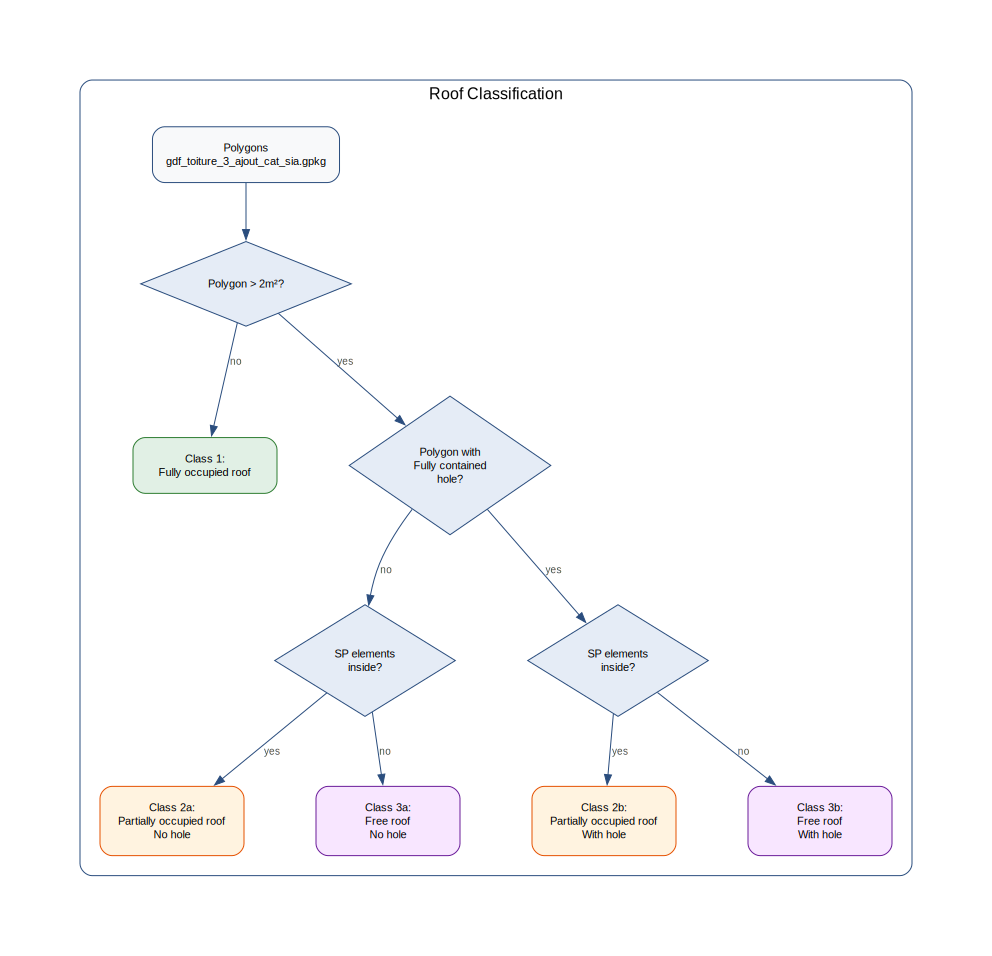

In [25]:
def create_optimized_data_flow_diagram():
    """
    Create detailed classification process diagram.
    
    Visualizes the decision tree for roof classification including
    all decision points and resulting classes.
    """
    g = Digraph("G", format="png")
    g.attr(
        rankdir="TB",
        bgcolor="transparent",
        fontname="Arial",
        pad="1.0",
        nodesep="1.0",
        ranksep="0.8",
        ratio="compress",
    )

    # Node style configuration
    g.attr(
        "node",
        shape="box",
        style="rounded,filled",
        fontname="Arial",
        fontsize="11",
        margin="0.2",
        width="2.0",
        height="0.5",
    )

    # Edge configuration
    g.attr(
        "edge", fontname="Arial", fontsize="10", color="#2A4D7E", fontcolor="#505050"
    )

    # Node styles
    start_style = {
        "fillcolor": "#F8F9FA",
        "color": "#2A4D7E",
        "style": "rounded,filled",
    }
    decision_style = {
        "shape": "diamond",
        "fillcolor": "#E5ECF6",
        "color": "#2A4D7E",
        "margin": "0.2",
        "style": "filled",
    }
    class1_style = {
        "fillcolor": "#E1F0E5",
        "color": "#2E7D32",
        "style": "rounded,filled",
    }
    class2_style = {
        "fillcolor": "#FFF3E0",
        "color": "#E65100",
        "style": "rounded,filled",
    }
    class3_style = {
        "fillcolor": "#F8E6FF",
        "color": "#6A1B9A",
        "style": "rounded,filled",
    }

    # Cluster creation
    with g.subgraph(name="cluster_0") as c:
        c.attr(
            label="Roof Classification",
            style="rounded",
            color="#2A4D7E",
            margin="20",
            fontsize="16",
        )

        # Node creation
        c.node("toiture", "Polygons\ngdf_toiture_3_ajout_cat_sia.gpkg", **start_style)
        c.node("surface", "Polygon > 2m²?", **decision_style)
        c.node("classe1", "Class 1:\nFully occupied roof", **class1_style)
        c.node("trou", "Polygon with\nFully contained\nhole?", **decision_style)
        c.node("sp_libre", "SP elements\ninside?", **decision_style)
        c.node("sp_partiel", "SP elements\ninside?", **decision_style)
        c.node(
            "classe2a",
            "Class 2a:\nPartially occupied roof\nNo hole",
            **class2_style
        )
        c.node(
            "classe2b",
            "Class 2b:\nPartially occupied roof\nWith hole",
            **class2_style
        )
        c.node("classe3a", "Class 3a:\nFree roof\nNo hole", **class3_style)
        c.node("classe3b", "Class 3b:\nFree roof\nWith hole", **class3_style)

        # Add edges
        c.edge("toiture", "surface")
        c.edge("surface", "classe1", " no")
        c.edge("surface", "trou", " yes")
        c.edge("trou", "sp_partiel", " yes")
        c.edge("trou", "sp_libre", " no")
        c.edge("sp_libre", "classe2a", " yes")
        c.edge("sp_libre", "classe3a", " no")
        c.edge("sp_partiel", "classe2b", " yes")
        c.edge("sp_partiel", "classe3b", " no")

    return g

# Generate and save
g = create_optimized_data_flow_diagram()
save_high_quality_graph(
    g, f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_03_classification_detail_classes", scale_factor=4
)
g

### Surface Area Filtering (< 2m²)

In [26]:
gdf_toiture_4_polgone_2m2 = gdf_toiture_3_ajout_cat_sia.copy()

# Create boolean column for surface > 2m²
SURFACE_LIMIT = 2
gdf_toiture_4_polgone_2m2["shape_area_sup_2m2"] = (
    gdf_toiture_4_polgone_2m2["SHAPE__Area"] > SURFACE_LIMIT
)

display(gdf_toiture_4_polgone_2m2.head(2))

# Save intermediate result
gdf_toiture_4_polgone_2m2.to_parquet(
   f"{OUTPUT_PARQUET_NOTEBOOK_02_PATH}/02_gdf_toiture_4_polgone_2m2.parquet"
)

,objectid,egid,altitude_min,altitude_max,date_leve,SHAPE__Length,SHAPE__Area,globalid,geometry,sia_cat,shape_area_sup_2m2
0,204857,295010023.0,462.00,465.46,2005-08-01 02:00:00,34.891045,69.277396,96076844-3ED9-4647-A7C3-F96D6CE16B71,"MULTIPOLYGON (((2491819.683 1110772.52, 249181...",II habitat individuel,True
1,204873,295010485.0,461.31,465.51,2005-08-01 02:00:00,42.022790,86.952040,987C8B52-793B-4BB1-85C5-D091BFA398D7,"MULTIPOLYGON (((2491841.218 1110782.921, 24918...",II habitat individuel,True


### Hole Detection in Roofs

Total geometries: 334269
Geometries with holes: 10973
Geometries with significant holes: 10922


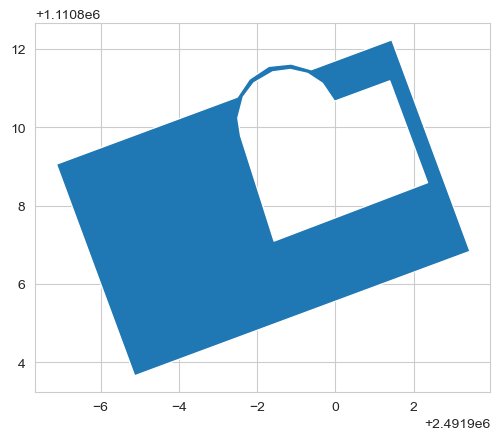

In [27]:
def is_fully_contained_hole(exterior, interior, min_area=2):
    """
    Check if a hole is fully contained within the polygon exterior.
    
    Validates that an interior ring (hole) is completely within the
    polygon boundary and meets minimum area requirements.

    Parameters:
        exterior (LinearRing): Polygon exterior boundary
        interior (LinearRing): Interior ring (hole)
        min_area (float): Minimum area to consider a valid hole

    Returns:
        bool: True if hole is valid and contained
    """
    exterior_poly = Polygon(exterior)
    interior_poly = Polygon(interior)

    # Check containment and minimum area
    if exterior_poly.contains(interior_poly) and interior_poly.area >= min_area:
        return True
    return False

def analyze_geometry_holes(geometry, min_area=2):
    """
    Analyze holes in a geometry.
    
    Processes both Polygon and MultiPolygon geometries to identify
    and characterize interior rings (holes).

    Parameters:
        geometry: Shapely geometry object (Polygon or MultiPolygon)
        min_area (float): Minimum area for valid hole

    Returns:
        dict: Hole analysis results
    """
    if geometry is None or not geometry.is_valid:
        return {
            "has_holes": False,
            "hole_count": 0,
            "hole_areas": [],
            "total_hole_area": 0,
            "valid_geometry": False,
        }

    contained_holes = []
    total_holes = 0

    if isinstance(geometry, Polygon):
        exterior = geometry.exterior
        for interior in geometry.interiors:
            total_holes += 1
            if is_fully_contained_hole(exterior, interior, min_area):
                contained_holes.append(Polygon(interior))

    elif isinstance(geometry, MultiPolygon):
        for poly in geometry.geoms:
            exterior = poly.exterior
            for interior in poly.interiors:
                total_holes += 1
                if is_fully_contained_hole(exterior, interior, min_area):
                    contained_holes.append(Polygon(interior))

    hole_areas = [hole.area for hole in contained_holes]

    return {
        "has_holes": len(contained_holes) > 0,
        "hole_count": len(contained_holes),
        "total_holes_checked": total_holes,
        "hole_areas": hole_areas,
        "total_hole_area": sum(hole_areas),
        "valid_geometry": True,
    }

def analyze_holes_in_gdf(gdf, geometry_column="geometry", min_area=200):
    """
    Analyze holes in all geometries of a GeoDataFrame.
    
    Applies hole detection analysis to an entire GeoDataFrame and
    adds relevant analysis columns.

    Parameters:
        gdf (GeoDataFrame): Input GeoDataFrame
        geometry_column (str): Geometry column name
        min_area (float): Minimum area for valid hole

    Returns:
        GeoDataFrame: GeoDataFrame with hole analysis columns added
    """
    # Apply analysis to each geometry
    results = gdf[geometry_column].apply(
        lambda geom: analyze_geometry_holes(geom, min_area=min_area)
    )

    # Extract results
    gdf["has_fully_contained_holes"] = results.apply(lambda x: x["has_holes"])
    gdf["fully_contained_hole_count"] = results.apply(lambda x: x["hole_count"])
    gdf["total_hole_area"] = results.apply(lambda x: x["total_hole_area"])
    gdf["valid_geometry"] = results.apply(lambda x: x["valid_geometry"])

    # Calculate hole/total area ratio
    gdf["hole_area_ratio"] = gdf["total_hole_area"] / gdf[geometry_column].area

    return gdf

def find_significant_holes(gdf, min_hole_area_ratio=0.01):
    """
    Filter geometries with significant holes.
    
    Identifies geometries where holes represent a significant portion
    of the total polygon area.

    Parameters:
        gdf (GeoDataFrame): GeoDataFrame with hole analysis
        min_hole_area_ratio (float): Minimum hole/polygon ratio

    Returns:
        GeoDataFrame: Geometries with significant holes
    """
    return gdf[
        (gdf["has_fully_contained_holes"])
        & (gdf["valid_geometry"])
        & (gdf["hole_area_ratio"] >= min_hole_area_ratio)
    ]

# Apply analysis
gdf_toiture_5_hole = gdf_toiture_4_polgone_2m2.copy()
gdf_toiture_5_hole = analyze_holes_in_gdf(gdf_toiture_5_hole, min_area=2)

# Identify significant holes
significant_holes = find_significant_holes(gdf_toiture_5_hole, min_hole_area_ratio=0.01)

# Display results
print(f"Total geometries: {len(gdf_toiture_5_hole)}")
print(
    f"Geometries with holes: {len(gdf_toiture_5_hole[gdf_toiture_5_hole['fully_contained_hole_count'] > 0])}"
)
print(f"Geometries with significant holes: {len(significant_holes)}")

significant_holes.head(1).plot()

# Save
significant_holes.to_parquet(
   f"{OUTPUT_PARQUET_NOTEBOOK_02_PATH}/02_gdf_toiture_5_hole.parquet"
)

### Superstructure Analysis in Roofs

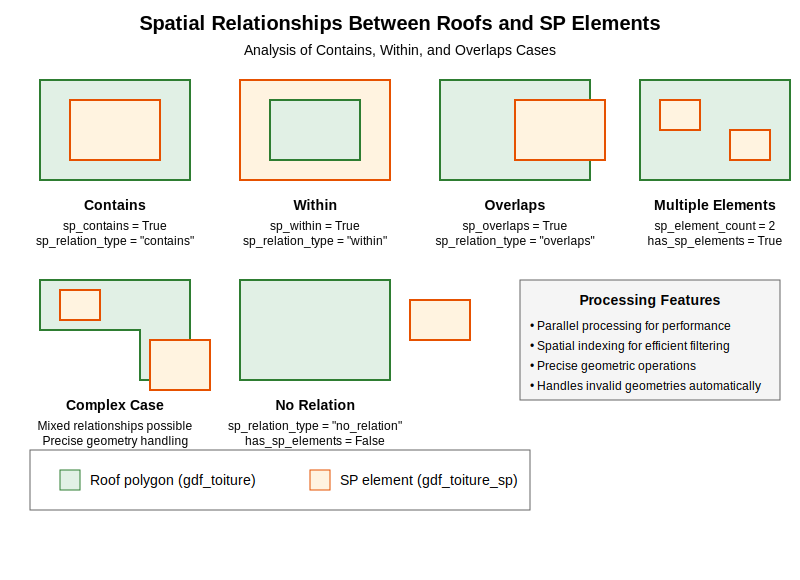

PNG saved: 6400x4640 pixels


In [28]:
gdf_toiture_6_contains_SP_svg_content = """<svg viewBox="0 0 800 580" xmlns="http://www.w3.org/2000/svg">
    <!-- Title -->
    <text x="400" y="30" text-anchor="middle" font-family="Arial" font-size="20" font-weight="bold">Spatial Relationships Between Roofs and SP Elements</text>
    <text x="400" y="55" text-anchor="middle" font-family="Arial" font-size="14">Analysis of Contains, Within, and Overlaps Cases</text>
    
    <!-- Row 1: Basic Cases -->
    <g transform="translate(40,80)">
        <g>
            <!-- Contains -->
            <rect x="0" y="0" width="150" height="100" fill="#E1F0E5" stroke="#2E7D32" stroke-width="2"/>
            <rect x="30" y="20" width="90" height="60" fill="#FFF3E0" stroke="#E65100" stroke-width="2"/>
            <text x="75" y="130" text-anchor="middle" font-family="Arial" font-size="14" font-weight="bold">Contains</text>
            <text x="75" y="150" text-anchor="middle" font-family="Arial" font-size="12">sp_contains = True</text>
            <text x="75" y="165" text-anchor="middle" font-family="Arial" font-size="12">sp_relation_type = "contains"</text>
        </g>
    </g>
    
    <g transform="translate(240,80)">
        <!-- Within -->
        <rect x="0" y="0" width="150" height="100" fill="#FFF3E0" stroke="#E65100" stroke-width="2"/>
        <rect x="30" y="20" width="90" height="60" fill="#E1F0E5" stroke="#2E7D32" stroke-width="2"/>
        <text x="75" y="130" text-anchor="middle" font-family="Arial" font-size="14" font-weight="bold">Within</text>
        <text x="75" y="150" text-anchor="middle" font-family="Arial" font-size="12">sp_within = True</text>
        <text x="75" y="165" text-anchor="middle" font-family="Arial" font-size="12">sp_relation_type = "within"</text>
    </g>

    <g transform="translate(440,80)">
        <!-- Overlaps -->
        <rect x="0" y="0" width="150" height="100" fill="#E1F0E5" stroke="#2E7D32" stroke-width="2"/>
        <rect x="75" y="20" width="90" height="60" fill="#FFF3E0" stroke="#E65100" stroke-width="2"/>
        <text x="75" y="130" text-anchor="middle" font-family="Arial" font-size="14" font-weight="bold">Overlaps</text>
        <text x="75" y="150" text-anchor="middle" font-family="Arial" font-size="12">sp_overlaps = True</text>
        <text x="75" y="165" text-anchor="middle" font-family="Arial" font-size="12">sp_relation_type = "overlaps"</text>
    </g>

    <g transform="translate(640,80)">
        <!-- Multiple Elements -->
        <rect x="0" y="0" width="150" height="100" fill="#E1F0E5" stroke="#2E7D32" stroke-width="2"/>
        <rect x="20" y="20" width="40" height="30" fill="#FFF3E0" stroke="#E65100" stroke-width="2"/>
        <rect x="90" y="50" width="40" height="30" fill="#FFF3E0" stroke="#E65100" stroke-width="2"/>
        <text x="75" y="130" text-anchor="middle" font-family="Arial" font-size="14" font-weight="bold">Multiple Elements</text>
        <text x="75" y="150" text-anchor="middle" font-family="Arial" font-size="12">sp_element_count = 2</text>
        <text x="75" y="165" text-anchor="middle" font-family="Arial" font-size="12">has_sp_elements = True</text>
    </g>

    <!-- Row 2: Complex Cases -->
    <g transform="translate(40,280)">
        <!-- Complex Case -->
        <path d="M0,0 L150,0 L150,100 L100,100 L100,50 L0,50 Z" fill="#E1F0E5" stroke="#2E7D32" stroke-width="2"/>
        <rect x="20" y="10" width="40" height="30" fill="#FFF3E0" stroke="#E65100" stroke-width="2"/>
        <rect x="110" y="60" width="60" height="50" fill="#FFF3E0" stroke="#E65100" stroke-width="2"/>
        <text x="75" y="130" text-anchor="middle" font-family="Arial" font-size="14" font-weight="bold">Complex Case</text>
        <text x="75" y="150" text-anchor="middle" font-family="Arial" font-size="12">Mixed relationships possible</text>
        <text x="75" y="165" text-anchor="middle" font-family="Arial" font-size="12">Precise geometry handling</text>
    </g>

    <g transform="translate(240,280)">
        <!-- No Relation - SP element moved further to avoid overlap -->
        <rect x="0" y="0" width="150" height="100" fill="#E1F0E5" stroke="#2E7D32" stroke-width="2"/>
        <rect x="170" y="20" width="60" height="40" fill="#FFF3E0" stroke="#E65100" stroke-width="2"/>
        <text x="75" y="130" text-anchor="middle" font-family="Arial" font-size="14" font-weight="bold">No Relation</text>
        <text x="75" y="150" text-anchor="middle" font-family="Arial" font-size="12">sp_relation_type = "no_relation"</text>
        <text x="75" y="165" text-anchor="middle" font-family="Arial" font-size="12">has_sp_elements = False</text>
    </g>

    <!-- Processing Features Box - Moved further right -->
    <g transform="translate(520,280)">
        <rect x="0" y="0" width="260" height="120" fill="#F5F5F5" stroke="#666666" stroke-width="1"/>
        <text x="130" y="25" text-anchor="middle" font-family="Arial" font-size="14" font-weight="bold">Processing Features</text>
        <text x="10" y="50" font-family="Arial" font-size="12">• Parallel processing for performance</text>
        <text x="10" y="70" font-family="Arial" font-size="12">• Spatial indexing for efficient filtering</text>
        <text x="10" y="90" font-family="Arial" font-size="12">• Precise geometric operations</text>
        <text x="10" y="110" font-family="Arial" font-size="12">• Handles invalid geometries automatically</text>
    </g>

    <!-- Legend Box - Simplified -->
    <g transform="translate(40,460)">
        <!-- Background -->
        <rect x="-10" y="-10" width="500" height="60" fill="white" stroke="#666666" stroke-width="1"/>
        
        <!-- Legend content -->
        <g transform="translate(20,20)">
            <!-- First item -->
            <g transform="translate(0,0)">
                <rect x="0" y="-10" width="20" height="20" fill="#E1F0E5" stroke="#2E7D32" stroke-width="1"/>
                <text x="30" y="5" font-family="Arial" font-size="14">Roof polygon (gdf_toiture)</text>
            </g>
            
            <!-- Second item -->
            <g transform="translate(250,0)">
                <rect x="0" y="-10" width="20" height="20" fill="#FFF3E0" stroke="#E65100" stroke-width="1"/>
                <text x="30" y="5" font-family="Arial" font-size="14">SP element (gdf_toiture_sp)</text>
            </g>
        </g>
    </g>
</svg>"""

# Save and display SVG
save_and_display_svg(
    gdf_toiture_6_contains_SP_svg_content, 
    f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_05_gdf_toiture_6_contains_SP.svg"
)

In [29]:
def analyze_sp_elements_presence(gdf_toiture, gdf_toiture_sp):
    """
    Analyze presence and spatial relationships of SP elements 
    (superstructures) within roof polygons.
    
    Performs detailed spatial analysis to determine how SP elements
    interact with roof polygons using spatial indexing and parallel
    processing for efficiency.
    
    Parameters:
        gdf_toiture (GeoDataFrame): Roof polygons
        gdf_toiture_sp (GeoDataFrame): SP elements
    
    Returns:
        GeoDataFrame: Enriched GeoDataFrame with SP information
    """
    # Suppress non-critical warnings
    warnings.filterwarnings('ignore', category=ShapelyDeprecationWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    # Initialize and prepare data
    gdf_result = gdf_toiture.copy()

    # Align coordinate systems
    if gdf_toiture.crs != gdf_toiture_sp.crs:
        print("Converting CRS to match roof polygons...")
        gdf_toiture_sp = gdf_toiture_sp.to_crs(gdf_toiture.crs)

    # Validate geometries
    print("Validating geometries...")
    gdf_result["geometry"] = gdf_result.geometry.make_valid()
    gdf_toiture_sp["geometry"] = gdf_toiture_sp.geometry.make_valid()

    # Initialize result columns
    gdf_result["sp_contains"] = False
    gdf_result["sp_within"] = False
    gdf_result["sp_overlaps"] = False
    gdf_result["sp_element_count"] = 0
    gdf_result["sp_relation_type"] = "no_relation"

    # Create spatial index for optimization
    spatial_index = gdf_toiture_sp.sindex

    def process_roof(roof_idx, roof_geom, sp_data, spatial_index):
        """
        Process a single roof polygon against all relevant SP elements.
        
        Parameters:
            roof_idx: Roof index
            roof_geom: Roof geometry
            sp_data: SP data
            spatial_index: Spatial index
            
        Returns:
            dict: Spatial analysis results
        """
        try:
            # Initial spatial filtering
            possible_matches_idx = list(spatial_index.intersection(roof_geom.bounds))

            if not possible_matches_idx:
                return {
                    'idx': roof_idx,
                    'contains': False,
                    'within': False,
                    'overlaps': False,
                    'count': 0,
                    'relation': "no_relation"
                }

            # Refined spatial analysis
            possible_matches = sp_data.iloc[possible_matches_idx]
            intersecting = possible_matches[possible_matches.geometry.intersects(roof_geom)]

            if intersecting.empty:
                return {
                    'idx': roof_idx,
                    'contains': False,
                    'within': False,
                    'overlaps': False,
                    'count': 0,
                    'relation': "no_relation"
                }

            # Detailed geometric analysis
            try:
                clipped = intersecting.copy()
                clipped['clipped_geom'] = intersecting.geometry.intersection(roof_geom)
                clipped = clipped[~clipped['clipped_geom'].is_empty]

                if clipped.empty:
                    return {
                        'idx': roof_idx,
                        'contains': False,
                        'within': False,
                        'overlaps': False,
                        'count': 0,
                        'relation': "no_relation"
                    }

                # Determine precise spatial relationships
                contains_any = any(roof_geom.contains(geom) for geom in clipped['geometry'])
                within_any = any(roof_geom.within(geom) for geom in clipped['geometry'])

                relation_type = "overlaps"
                if contains_any:
                    relation_type = "contains"
                elif within_any:
                    relation_type = "within"

                return {
                    'idx': roof_idx,
                    'contains': contains_any,
                    'within': within_any,
                    'overlaps': not (contains_any or within_any),
                    'count': len(clipped),
                    'relation': relation_type
                }

            except Exception as e:
                print(f"Warning: Clipping failed for roof {roof_idx}: {e}")
                return {
                    'idx': roof_idx,
                    'contains': False,
                    'within': False,
                    'overlaps': False,
                    'count': 0,
                    'relation': "error"
                }

        except Exception as e:
            print(f"Warning: Error processing roof at index {roof_idx}: {e}")
            return {
                'idx': roof_idx,
                'contains': False,
                'within': False,
                'overlaps': False,
                'count': 0,
                'relation': "error"
            }

    # Configure parallel processing
    n_cores = multiprocessing.cpu_count()
    batch_size = max(1, len(gdf_result) // (n_cores * 2))
    n_workers = min(n_cores, max(1, len(gdf_result) // batch_size))

    print(f"\nStarting parallel processing with {n_workers} workers")
    print(f"Batch size: {batch_size}")

    # Execute parallel processing
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = []
        for idx, roof in gdf_result.iterrows():
            futures.append(
                executor.submit(
                    process_roof,
                    idx,
                    roof.geometry,
                    gdf_toiture_sp,
                    spatial_index
                )
            )

        # Collect results with progress bar
        results = []
        for future in tqdm(as_completed(futures), 
                          total=len(futures), 
                          desc="Processing roofs"):
            results.append(future.result())

    # Update results
    print("\nUpdating results...")
    for result in results:
        idx = result['idx']
        gdf_result.at[idx, "sp_contains"] = result['contains']
        gdf_result.at[idx, "sp_within"] = result['within']
        gdf_result.at[idx, "sp_overlaps"] = result['overlaps']
        gdf_result.at[idx, "sp_element_count"] = result['count']
        gdf_result.at[idx, "sp_relation_type"] = result['relation']

    # Calculate global SP presence flag
    gdf_result["has_sp_elements"] = (
        gdf_result["sp_contains"] | 
        gdf_result["sp_within"] | 
        gdf_result["sp_overlaps"]
    )

    # Summary statistics
    print("\nAnalysis complete - Summary statistics:")
    print(f"Total roof polygons processed: {len(gdf_result)}")
    print("\nSpatial relationship distribution:")
    print(gdf_result["sp_relation_type"].value_counts())
    print("\nSP element count distribution:")
    print(gdf_result["sp_element_count"].value_counts().sort_index())

    return gdf_result

# Execute detailed spatial analysis
gdf_toiture_6_contains_SP = analyze_sp_elements_presence(
    gdf_toiture_5_hole, gdf_toiture_sp_2_filtre_egid
)

# Verify results
print("\nAnalysis results:")
print(
    f"Total roofs with SP elements: {gdf_toiture_6_contains_SP['has_sp_elements'].sum()}"
)
print("\nRelationship types:")
print(gdf_toiture_6_contains_SP["sp_relation_type"].value_counts())

Validating geometries...


/opt/homebrew/Caskroom/miniconda/base/envs/rooftops/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)



Starting parallel processing with 8 workers
Batch size: 20891


Processing roofs:   0%|          | 0/334269 [00:00<?, ?it/s]


Updating results...

Analysis complete - Summary statistics:
Total roof polygons processed: 334269

Spatial relationship distribution:
sp_relation_type
no_relation    300740
contains        24954
overlaps         8573
within              2
Name: count, dtype: int64

SP element count distribution:
sp_element_count
0      300740
1       13679
2        7607
3        2918
4        2802
        ...  
245         1
343         1
384         1
397         1
417         1
Name: count, Length: 108, dtype: int64

Analysis results:
Total roofs with SP elements: 33529

Relationship types:
sp_relation_type
no_relation    300740
contains        24954
overlaps         8573
within              2
Name: count, dtype: int64


/var/folders/pb/35wzjj9x67zbxnzt_m0bv5dw0000gn/T/ipykernel_3106/3959646576.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=relationship_counts.index,


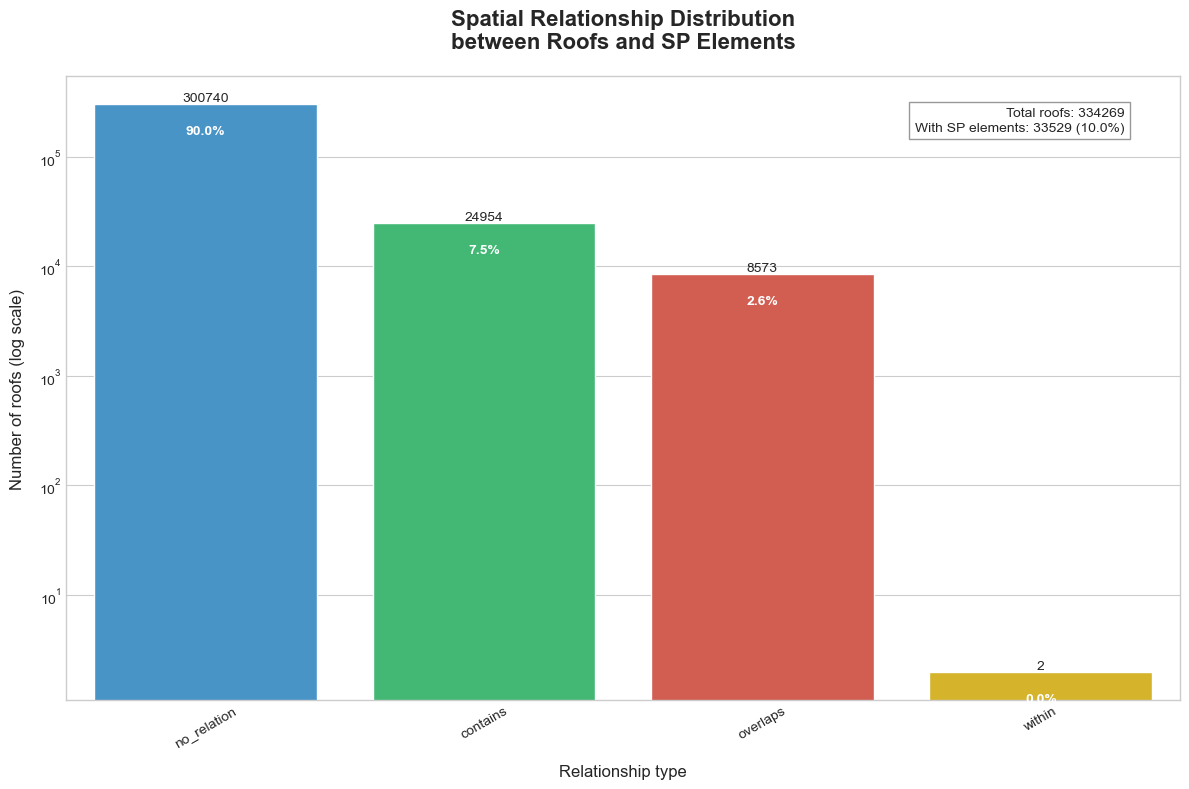

/var/folders/pb/35wzjj9x67zbxnzt_m0bv5dw0000gn/T/ipykernel_3106/3959646576.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_with_sp, x='sp_relation_type', y='sp_element_count',


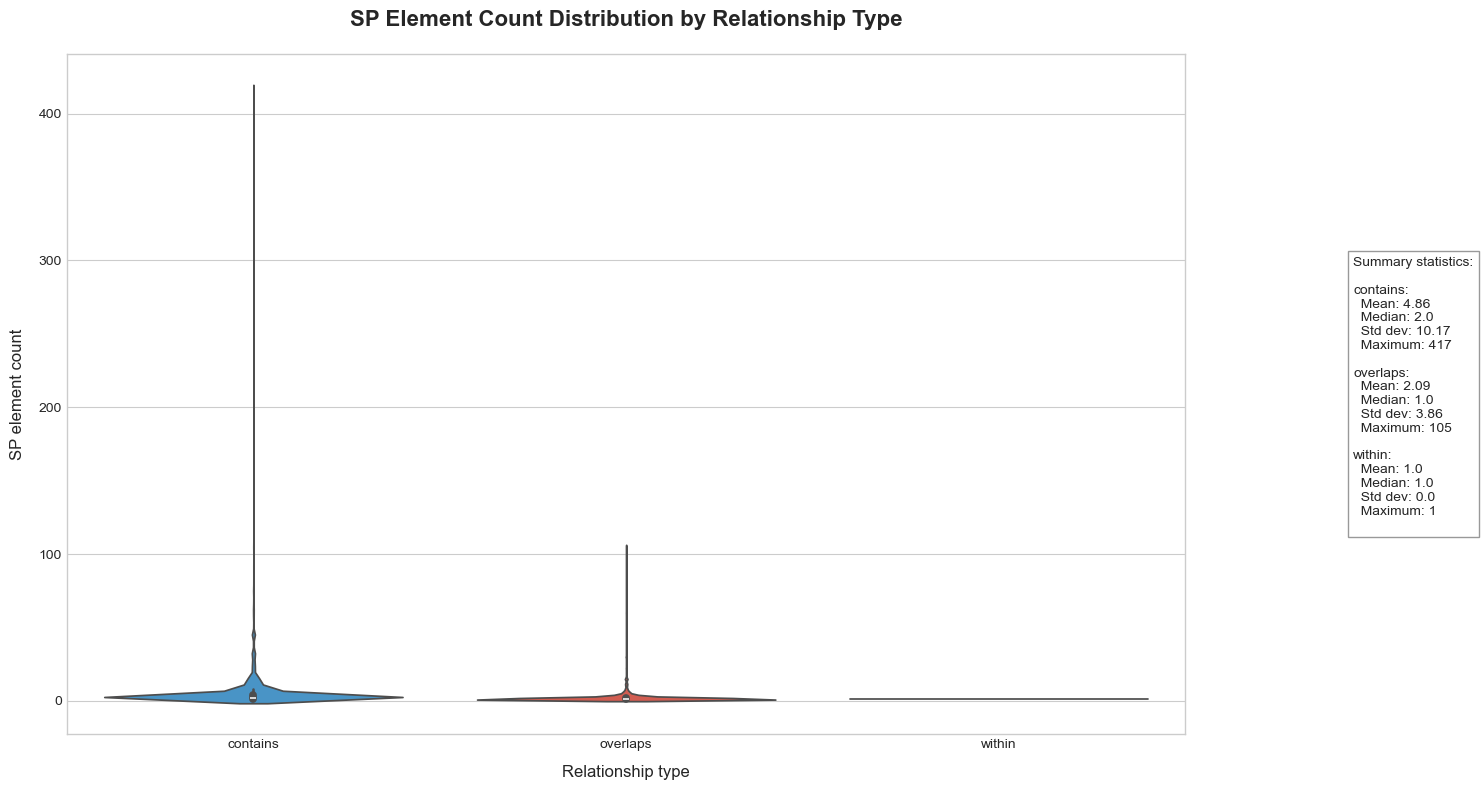

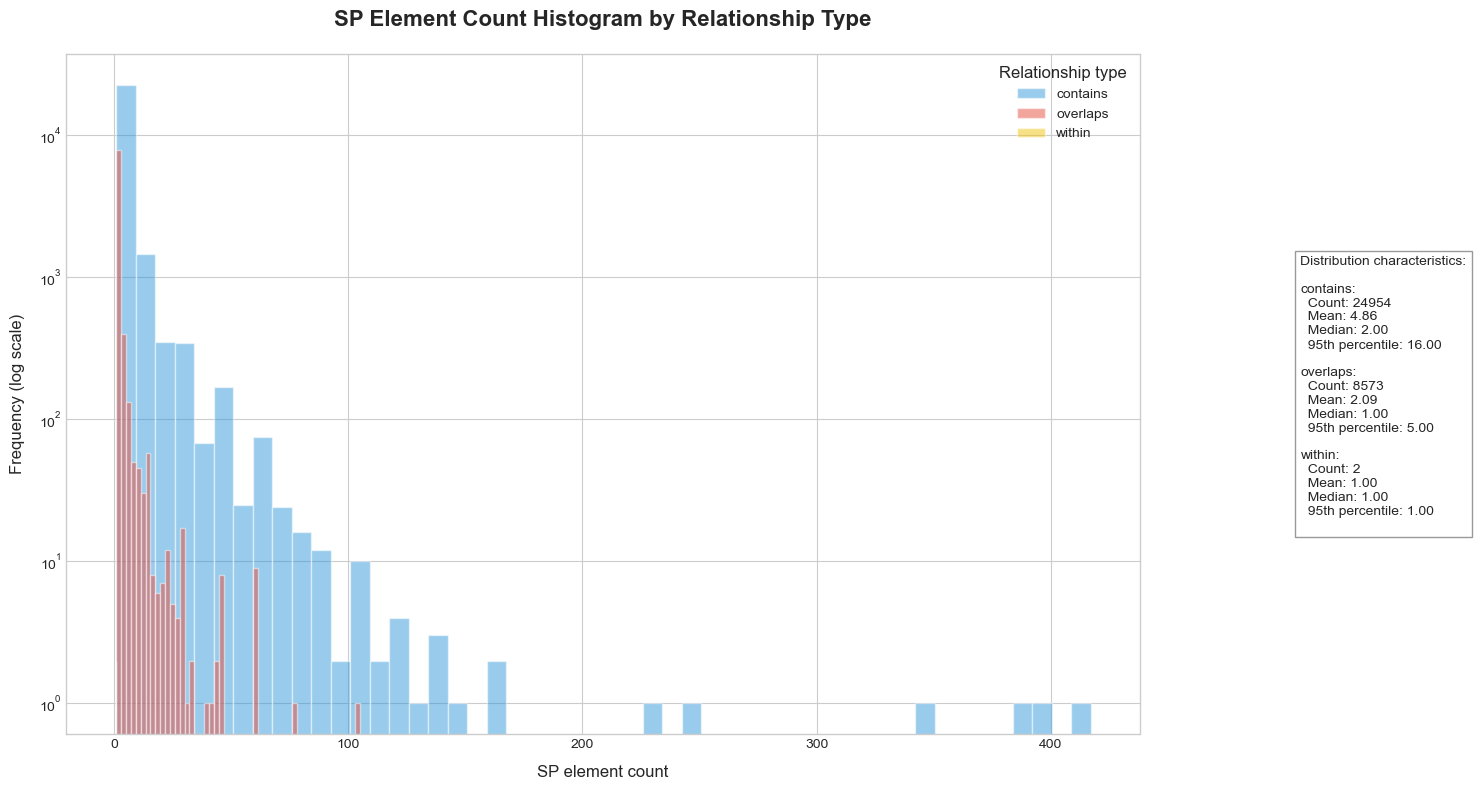

In [38]:
def create_report_plots(df):
    """
    Create publication-quality plots for spatial analysis report.
    
    Generates comprehensive visualizations showing the distribution of
    spatial relationships and SP element counts.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")

    # 1. Relationship distribution plot
    plt.figure(figsize=(12, 8))
    relationship_counts = df['sp_relation_type'].value_counts()

    # Bar plot with custom colors
    bars = sns.barplot(x=relationship_counts.index, 
                      y=relationship_counts.values,
                      palette=['#3498db', '#2ecc71', '#e74c3c', '#f1c40f'])

    # Add values and percentages
    total = len(df)
    for i, v in enumerate(relationship_counts.values):
        percentage = v/total*100
        plt.text(i, v, f'{v}', 
                ha='center', va='bottom', fontsize=10)
        plt.text(i, v/2, f'{percentage:.1f}%',
                ha='center', va='bottom', 
                color='white', fontweight='bold', fontsize=10)

    plt.title('Spatial Relationship Distribution\nbetween Roofs and SP Elements',
              fontsize=16, pad=20, fontweight='bold')
    plt.xlabel('Relationship type', fontsize=12, labelpad=10)
    plt.ylabel('Number of roofs (log scale)', fontsize=12, labelpad=10)
    plt.yscale('log')
    plt.xticks(rotation=30)

    # Description box
    description = (
        f'Total roofs: {total}\n'
        f'With SP elements: {df["has_sp_elements"].sum()} ({df["has_sp_elements"].mean()*100:.1f}%)'
    )
    plt.text(0.95, 0.95, description,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
             ha='right', va='top', fontsize=10)

    plt.savefig(
        f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_06_analyse_relation_toitures_avec_sp_distribution.png",
        dpi=300,
        bbox_inches="tight",
    )

    plt.tight_layout()
    plt.show()

    # 2. Element count distribution (excluding no_relation)
    plt.figure(figsize=(15, 8))

    df_with_sp = df[df['sp_relation_type'] != 'no_relation']

    sns.violinplot(data=df_with_sp, x='sp_relation_type', y='sp_element_count',
                  palette=['#3498db', '#e74c3c', '#f1c40f'])

    plt.title('SP Element Count Distribution by Relationship Type',
              fontsize=16, pad=20, fontweight='bold')
    plt.xlabel('Relationship type', fontsize=12, labelpad=10)
    plt.ylabel('SP element count', fontsize=12, labelpad=10)

    # Summary statistics
    stats = df_with_sp.groupby('sp_relation_type')['sp_element_count'].agg([
        'mean', 'median', 'std', 'max'
    ]).round(2)

    stats_text = "Summary statistics:\n"
    for idx in stats.index:
        stats_text += f"\n{idx}:\n"
        stats_text += f"  Mean: {stats.loc[idx, 'mean']}\n"
        stats_text += f"  Median: {stats.loc[idx, 'median']}\n"
        stats_text += f"  Std dev: {stats.loc[idx, 'std']}\n"
        stats_text += f"  Maximum: {stats.loc[idx, 'max']}\n"

    plt.text(1.15, 0.5, stats_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
             fontsize=10, va='center')

    plt.savefig(
        f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_08_analyse_relation_toitures_avec_sp_element_count.png",
        dpi=300,
        bbox_inches="tight",
    )

    plt.tight_layout()
    plt.show()

    # 3. Detailed element count histogram
    plt.figure(figsize=(15, 8))

    relationship_types = ['contains', 'overlaps', 'within']
    colors = ['#3498db', '#e74c3c', '#f1c40f']

    for rtype, color in zip(relationship_types, colors):
        data = df_with_sp[df_with_sp['sp_relation_type'] == rtype]['sp_element_count']
        plt.hist(data, bins=50, alpha=0.5, label=rtype, color=color)

    plt.title('SP Element Count Histogram by Relationship Type',
              fontsize=16, pad=20, fontweight='bold')
    plt.xlabel('SP element count', fontsize=12, labelpad=10)
    plt.ylabel('Frequency (log scale)', fontsize=12, labelpad=10)
    plt.yscale('log')
    plt.legend(title='Relationship type', fontsize=10, title_fontsize=12)

    # Summary text
    summary_text = "Distribution characteristics:\n"
    for rtype in relationship_types:
        data = df_with_sp[df_with_sp['sp_relation_type'] == rtype]['sp_element_count']
        summary_text += f"\n{rtype}:\n"
        summary_text += f"  Count: {len(data)}\n"
        summary_text += f"  Mean: {data.mean():.2f}\n"
        summary_text += f"  Median: {data.median():.2f}\n"
        summary_text += f"  95th percentile: {data.quantile(0.95):.2f}\n"

    plt.text(1.15, 0.5, summary_text,
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
             fontsize=10, va='center')

    plt.savefig(
        f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_08_analyse_relation_toitures_avec_sp_histogramme.png",
        dpi=300,
        bbox_inches="tight",
    )

    plt.tight_layout()
    plt.show()

# Create and display plots
create_report_plots(gdf_toiture_6_contains_SP)

In [31]:
display(gdf_toiture_6_contains_SP.columns)
display(gdf_toiture_6_contains_SP.head(2))
display(gdf_toiture_6_contains_SP.dtypes)

Index(['objectid', 'egid', 'altitude_min', 'altitude_max', 'date_leve',
       'SHAPE__Length', 'SHAPE__Area', 'globalid', 'geometry', 'sia_cat',
       'shape_area_sup_2m2', 'has_fully_contained_holes',
       'fully_contained_hole_count', 'total_hole_area', 'valid_geometry',
       'hole_area_ratio', 'sp_contains', 'sp_within', 'sp_overlaps',
       'sp_element_count', 'sp_relation_type', 'has_sp_elements'],
      dtype='object')

,objectid,egid,altitude_min,altitude_max,date_leve,SHAPE__Length,SHAPE__Area,globalid,geometry,sia_cat,...,fully_contained_hole_count,total_hole_area,valid_geometry,hole_area_ratio,sp_contains,sp_within,sp_overlaps,sp_element_count,sp_relation_type,has_sp_elements
0,204857,295010023.0,462.00,465.46,2005-08-01 02:00:00,34.891045,69.277396,96076844-3ED9-4647-A7C3-F96D6CE16B71,"MULTIPOLYGON (((2491819.683 1110772.52, 249181...",II habitat individuel,...,0,0.0,True,0.0,False,False,False,0,no_relation,False
1,204873,295010485.0,461.31,465.51,2005-08-01 02:00:00,42.022790,86.952040,987C8B52-793B-4BB1-85C5-D091BFA398D7,"MULTIPOLYGON (((2491841.218 1110782.921, 24918...",II habitat individuel,...,0,0.0,True,0.0,True,False,False,4,contains,True


objectid                               int64
egid                                 float64
altitude_min                         float64
altitude_max                         float64
date_leve                     datetime64[ms]
SHAPE__Length                        float64
SHAPE__Area                          float64
globalid                              object
geometry                            geometry
sia_cat                               object
shape_area_sup_2m2                      bool
has_fully_contained_holes               bool
fully_contained_hole_count             int64
total_hole_area                      float64
valid_geometry                          bool
hole_area_ratio                      float64
sp_contains                             bool
sp_within                               bool
sp_overlaps                             bool
sp_element_count                       int64
sp_relation_type                      object
has_sp_elements                         bool
dtype: obj

In [32]:
# Save results
gdf_toiture_6_contains_SP.to_parquet(
   f"{OUTPUT_PARQUET_NOTEBOOK_02_PATH}/02_gdf_toiture_6_contains_SP.parquet"
)

### Application de la classification

In [33]:
gdf_toiture_7_classification = gdf_toiture_6_contains_SP.copy()

# Initialize classification columns
gdf_toiture_7_classification["classification"] = None
gdf_toiture_7_classification["classification_simplified"] = None
gdf_toiture_7_classification["classification_comment"] = None

# Class 1: Fully occupied roof (≤ 2m²)
mask_classe1 = (
    ~gdf_toiture_7_classification["shape_area_sup_2m2"]
    )
gdf_toiture_7_classification.loc[
    mask_classe1,
    ["classification", "classification_simplified" , "classification_comment"],
] = [
    "1",
    "1",
    "Class 1: Fully occupied roof"]

# Class 2a: Partially occupied roof without hole
mask_classe2a = (
    (gdf_toiture_7_classification["shape_area_sup_2m2"]) &
    (~gdf_toiture_7_classification["has_fully_contained_holes"]) &
    (gdf_toiture_7_classification["sp_element_count"] >= 1)
)
gdf_toiture_7_classification.loc[
    mask_classe2a,
    ["classification", "classification_simplified", "classification_comment"]] = [
    "2a",
    "2",
    "Class 2a: Partially occupied roof without hole",
]

# Class 2b: Partially occupied roof with hole
mask_classe2b = (
    (gdf_toiture_7_classification["shape_area_sup_2m2"]) &
    (gdf_toiture_7_classification["has_fully_contained_holes"]) &
    (gdf_toiture_7_classification["sp_element_count"] >= 1)
)
gdf_toiture_7_classification.loc[
    mask_classe2b,
    ["classification", "classification_simplified", "classification_comment"],
] = [
    "2b",
    "2",
    "Class 2b: Partially occupied roof with hole"]

# Class 3a: Free roof without hole
mask_classe3a = (
    (gdf_toiture_7_classification["shape_area_sup_2m2"]) &
    (~gdf_toiture_7_classification["has_fully_contained_holes"]) &
    (gdf_toiture_7_classification["sp_element_count"] == 0)
)
gdf_toiture_7_classification.loc[
    mask_classe3a,
    ["classification", "classification_simplified", "classification_comment"],
] = ["3a", "3", "Class 3a: Free roof without hole"]

# Class 3b: Free roof with hole
mask_classe3b = (
    (gdf_toiture_7_classification["shape_area_sup_2m2"]) &
    (gdf_toiture_7_classification["has_fully_contained_holes"]) &
    (gdf_toiture_7_classification["sp_element_count"] == 0)
)
gdf_toiture_7_classification.loc[
    mask_classe3b,
    ["classification", "classification_simplified", "classification_comment"],
] = ["3b", "3" ,"Class 3b: Free roof with hole"]

# Classification summary
print("\nClassification distribution:")
print(gdf_toiture_7_classification["classification"].value_counts())

# Check for unclassified roofs
unclassified = gdf_toiture_7_classification[gdf_toiture_7_classification["classification"].isna()]
if not unclassified.empty:
    print("\nWarning: Some roofs were not classified!")
    print(f"Number of unclassified roofs: {len(unclassified)}")
    print("\nSample of unclassified roofs:")
    print("Properties of unclassified roofs:")
    print(unclassified[["shape_area_sup_2m2", "has_fully_contained_holes", "sp_element_count"]].head())

# Detailed statistics
print("\nDetailed classification statistics:")
for classification in sorted(gdf_toiture_7_classification["classification"].unique()):
    if classification is not None:
        subset = gdf_toiture_7_classification[gdf_toiture_7_classification["classification"] == classification]
        print(f"\nClass {classification}:")
        print(f"Count: {len(subset)}")
        print("Average properties:")
        print(f"SP element count: {subset['sp_element_count'].mean():.2f}")

# Save results
gdf_toiture_7_classification.to_parquet(
   f"{OUTPUT_PARQUET_NOTEBOOK_02_PATH}/02_gdf_toiture_7_classification.parquet"
)


Classification distribution:
classification
3a    253207
1      40737
2a     29353
3b      7234
2b      3738
Name: count, dtype: int64

Detailed classification statistics:

Class 1:
Count: 40737
Average properties:
SP element count: 0.02

Class 2a:
Count: 29353
Average properties:
SP element count: 3.91

Class 2b:
Count: 3738
Average properties:
SP element count: 6.28

Class 3a:
Count: 253207
Average properties:
SP element count: 0.00

Class 3b:
Count: 7234
Average properties:
SP element count: 0.00


### Results Visualization

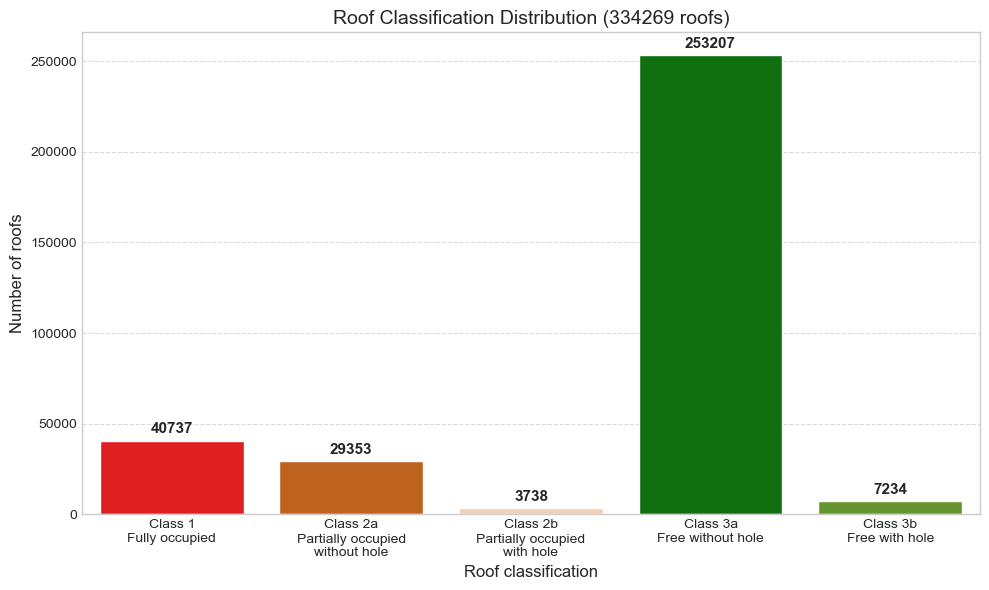


Classification distribution (percentage):
Class 1: 12.2% (40737 roofs)
Class 2a: 8.8% (29353 roofs)
Class 2b: 1.1% (3738 roofs)
Class 3a: 75.7% (253207 roofs)
Class 3b: 2.2% (7234 roofs)


In [34]:
# Define colors for each class
class_colors = {
    "1": "red",
    "2a": "#d95f02",
    "2b": "#fdcdac",
    "3a": "green",
    "3b": "#66a61e",
}

# Create figure
plt.figure(figsize=(10, 6))

# Bar plot with custom style
ax = sns.countplot(
    data=gdf_toiture_7_classification,
    x="classification",
    order=sorted(gdf_toiture_7_classification["classification"].unique()),
    hue="classification",
    palette=class_colors,
    legend=False
)

# Plot customization
plt.title(f"Roof Classification Distribution ({len(gdf_toiture_7_classification)} roofs)", fontsize=14)
plt.xlabel("Roof classification", fontsize=12)
plt.ylabel("Number of roofs", fontsize=12)

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add values on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        xy=(p.get_x() + p.get_width() / 2, height),
        textcoords="offset points",
        xytext=(0, 3),
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

# Class descriptions
class_descriptions = {
    "1": "Fully occupied",
    "2a": "Partially occupied\nwithout hole",
    "2b": "Partially occupied\nwith hole",
    "3a": "Free without hole",
    "3b": "Free with hole"
}

# Configure X-axis with descriptions
plt.xticks(range(len(class_descriptions)), 
           [f"Class {k}\n{v}" for k, v in class_descriptions.items()],
           rotation=0,
           ha='center')

plt.tight_layout()

# Save
plt.savefig(
    f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_09_gdf_toiture_7_classification_01_complete.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)

plt.show()

# Percentage distribution
total = len(gdf_toiture_7_classification)
print("\nClassification distribution (percentage):")
for classe in sorted(gdf_toiture_7_classification["classification"].unique()):
    count = len(gdf_toiture_7_classification[gdf_toiture_7_classification["classification"] == classe])
    percentage = (count / total) * 100
    print(f"Class {classe}: {percentage:.1f}% ({count} roofs)")


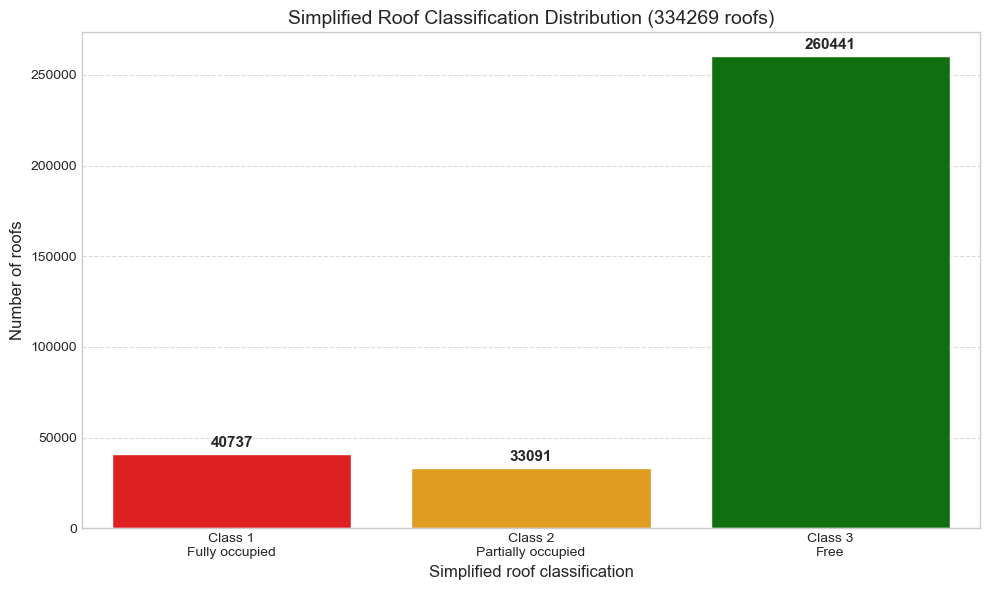


Simplified classification distribution (percentage):
Class 1: 12.2% (40737 roofs)
Class 2: 9.9% (33091 roofs)
Class 3: 77.9% (260441 roofs)


In [35]:
# Simplified classification plot
class_colors = {
    "1": "red",
    "2": "orange",
    "3": "green",
}

plt.figure(figsize=(10, 6))

ax = sns.countplot(
    data=gdf_toiture_7_classification,
    x="classification_simplified",
    order=sorted(gdf_toiture_7_classification["classification_simplified"].unique()),
    hue="classification_simplified",
    palette=class_colors,
    legend=False,
)

plt.title(
    f"Simplified Roof Classification Distribution ({len(gdf_toiture_7_classification)} roofs)",
    fontsize=14,
)
plt.xlabel("Simplified roof classification", fontsize=12)
plt.ylabel("Number of roofs", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add values on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        xy=(p.get_x() + p.get_width() / 2, height),
        textcoords="offset points",
        xytext=(0, 3),
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

# Simplified class descriptions
class_descriptions = {
    "1": "Fully occupied",
    "2": "Partially occupied",
    "3": "Free",
}

plt.xticks(
    range(len(class_descriptions)),
    [f"Class {k}\n{v}" for k, v in class_descriptions.items()],
    rotation=0,
    ha="center",
)

plt.tight_layout()

plt.savefig(
    f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_10_gdf_toiture_7_classification_02_simplified.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)

plt.show()

# Percentage distribution
total = len(gdf_toiture_7_classification)
print("\nSimplified classification distribution (percentage):")
for classe in sorted(
    gdf_toiture_7_classification["classification_simplified"].unique()
):
    count = len(
        gdf_toiture_7_classification[
            gdf_toiture_7_classification["classification_simplified"] == classe
        ]
    )
    percentage = (count / total) * 100
    print(f"Class {classe}: {percentage:.1f}% ({count} roofs)")

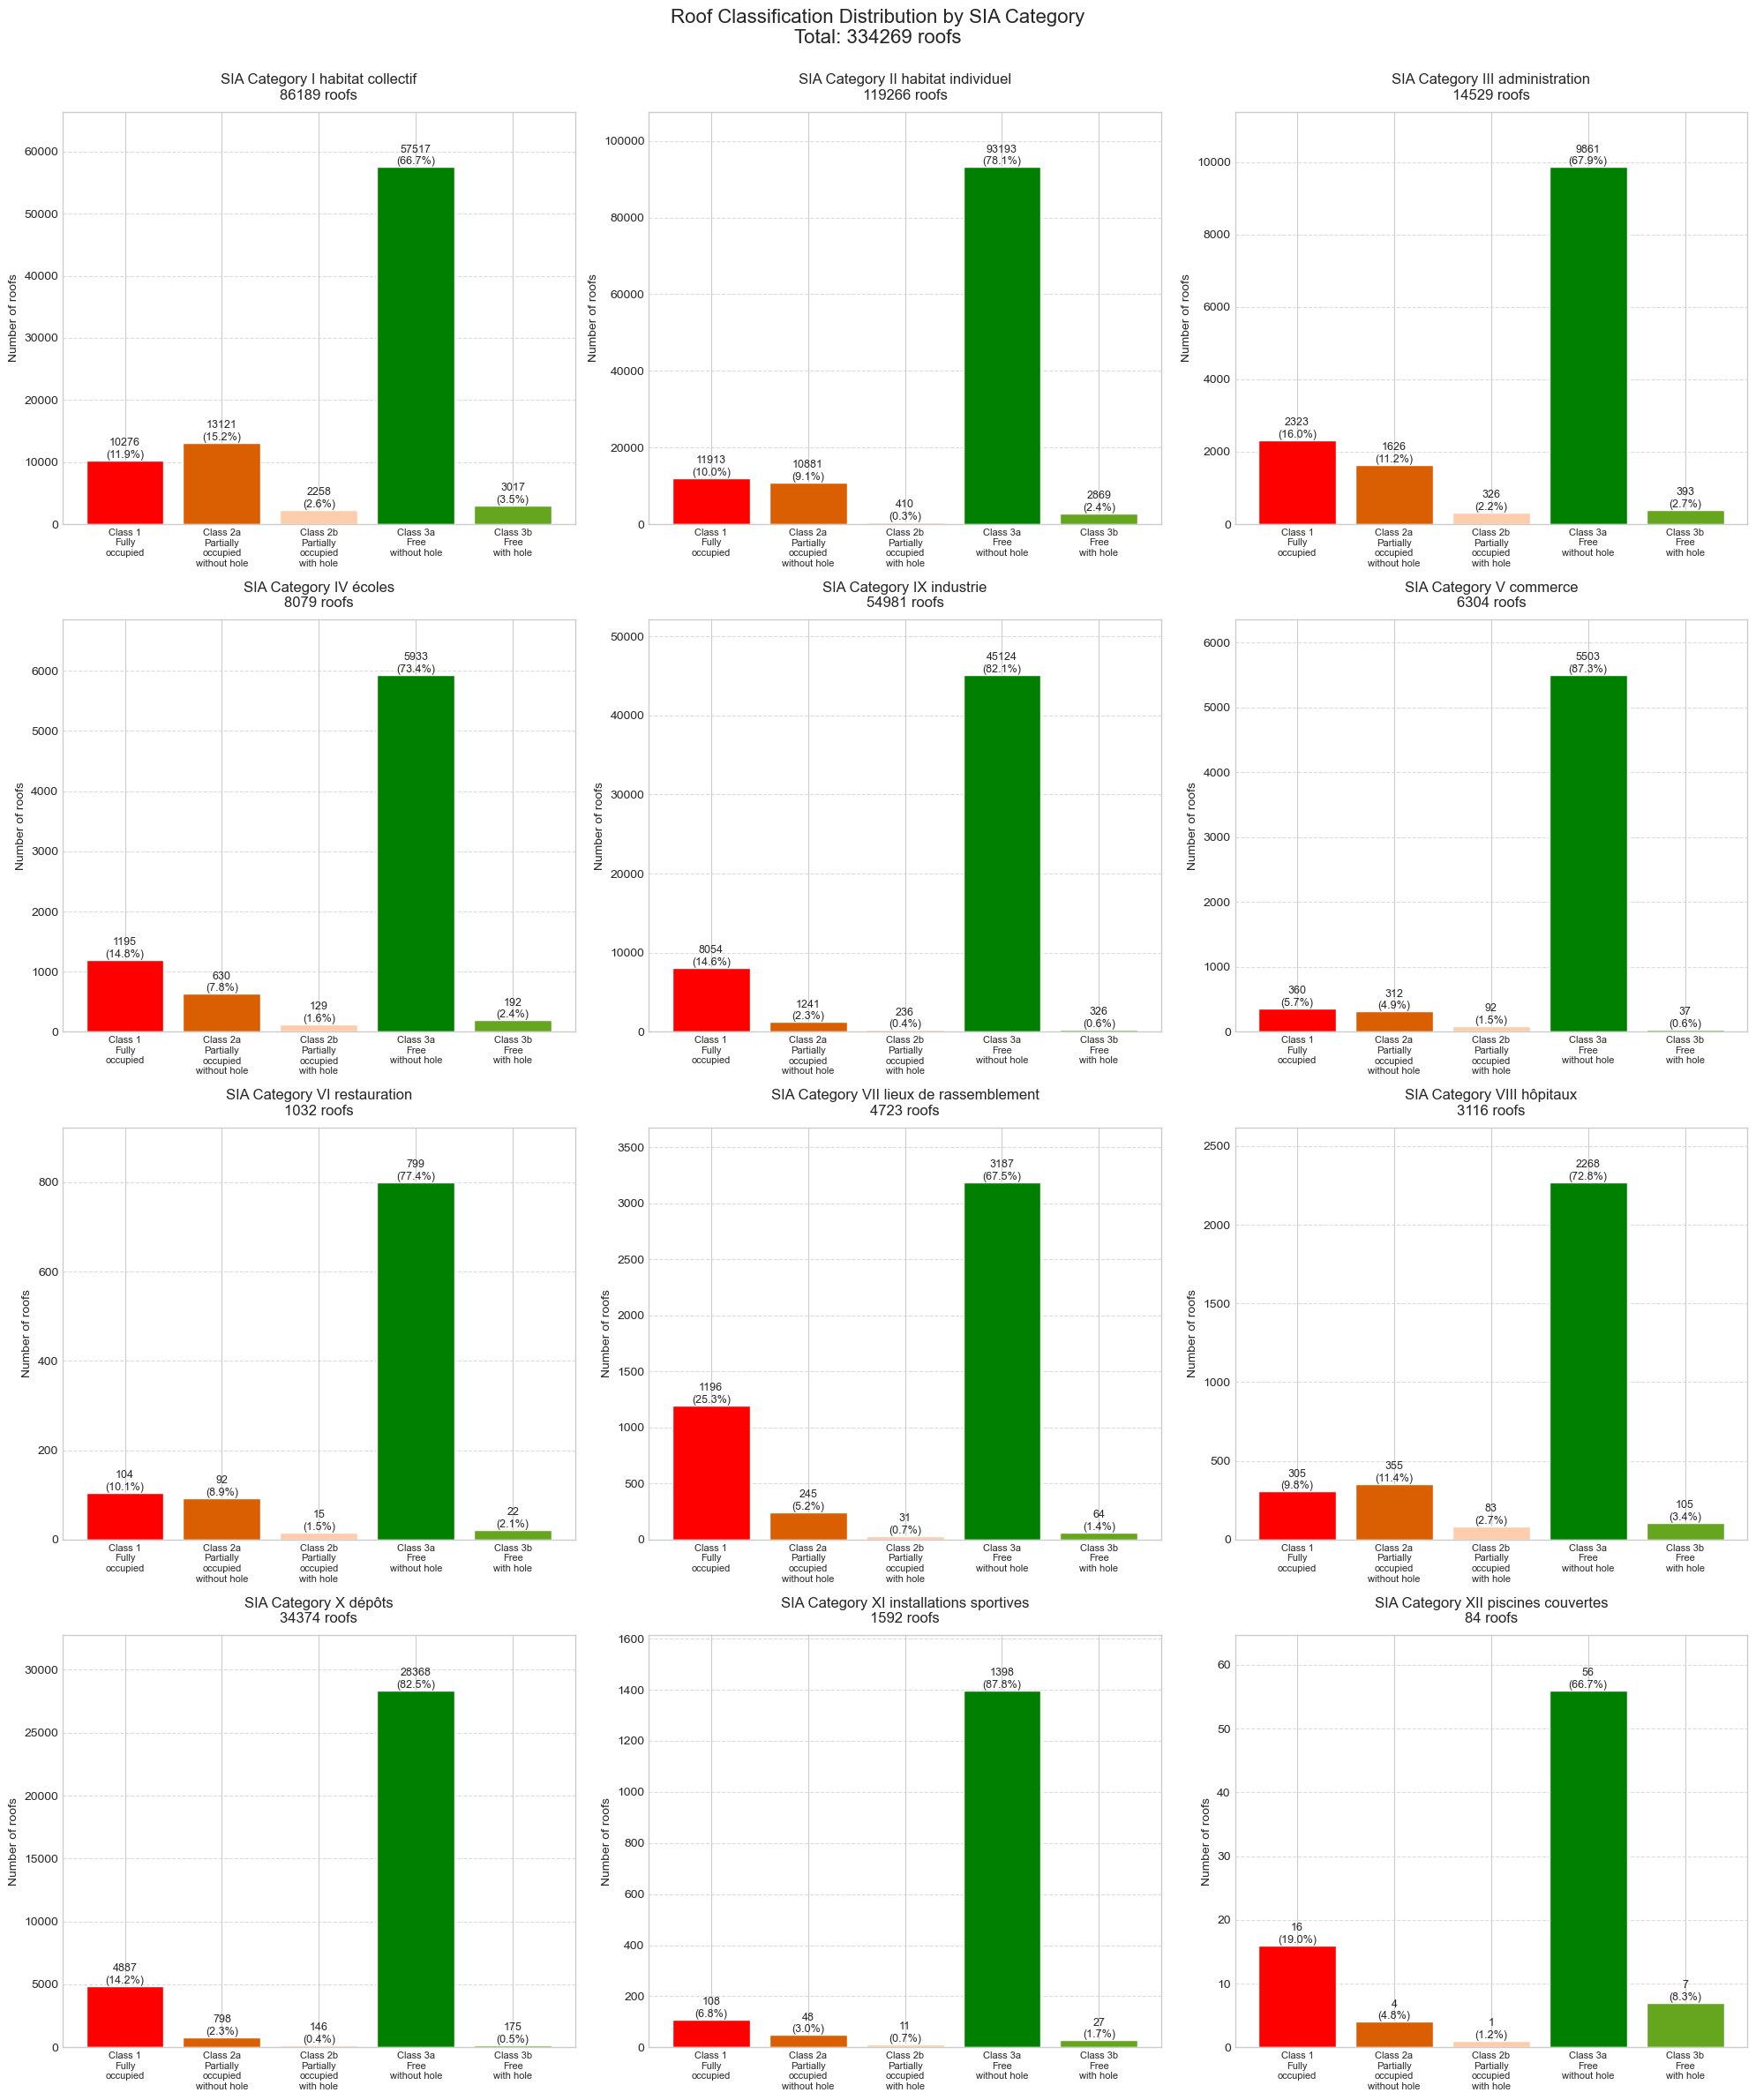


Detailed statistics by SIA category:

I habitat collectif (Total: 86189 roofs):
  Class 1: 11.9% (10276 roofs)
  Class 2a: 15.2% (13121 roofs)
  Class 2b: 2.6% (2258 roofs)
  Class 3a: 66.7% (57517 roofs)
  Class 3b: 3.5% (3017 roofs)

II habitat individuel (Total: 119266 roofs):
  Class 1: 10.0% (11913 roofs)
  Class 2a: 9.1% (10881 roofs)
  Class 2b: 0.3% (410 roofs)
  Class 3a: 78.1% (93193 roofs)
  Class 3b: 2.4% (2869 roofs)

III administration (Total: 14529 roofs):
  Class 1: 16.0% (2323 roofs)
  Class 2a: 11.2% (1626 roofs)
  Class 2b: 2.2% (326 roofs)
  Class 3a: 67.9% (9861 roofs)
  Class 3b: 2.7% (393 roofs)

IV écoles (Total: 8079 roofs):
  Class 1: 14.8% (1195 roofs)
  Class 2a: 7.8% (630 roofs)
  Class 2b: 1.6% (129 roofs)
  Class 3a: 73.4% (5933 roofs)
  Class 3b: 2.4% (192 roofs)

IX industrie (Total: 54981 roofs):
  Class 1: 14.6% (8054 roofs)
  Class 2a: 2.3% (1241 roofs)
  Class 2b: 0.4% (236 roofs)
  Class 3a: 82.1% (45124 roofs)
  Class 3b: 0.6% (326 roofs)

V comm

In [36]:
# Analysis by SIA category
# Handle missing values
gdf_toiture_7_classification['sia_cat'] = gdf_toiture_7_classification['sia_cat'].fillna('Undefined').astype(str)

# Color definitions
class_colors = {
    "1": "red",  
    "2a": "#d95f02",  
    "2b": "#fdcdac",  
    "3a": "green",
    "3b": "#66a61e",
}

# Class descriptions
class_descriptions = {
    "1": "Fully\noccupied",
    "2a": "Partially\noccupied\nwithout hole",
    "2b": "Partially\noccupied\nwith hole",
    "3a": "Free\nwithout hole",
    "3b": "Free\nwith hole"
}

# Unique SIA categories
sia_cats = sorted(gdf_toiture_7_classification['sia_cat'].unique())
n_cats = len(sia_cats)

# Subplot grid dimensions
n_cols = 3
n_rows = int(np.ceil(n_cats / n_cols))

# Create figure
fig = plt.figure(figsize=(20, 25))

# Main title
total_roofs = len(gdf_toiture_7_classification)
fig.suptitle('Roof Classification Distribution by SIA Category\n' + 
             f'Total: {total_roofs} roofs',
             fontsize=16, y=0.95)

# Custom category names
category_names = {
    "A": "Collective housing",
    "B": "Individual housing",
    "C": "Administration",
    "D": "Schools",
    "E": "Industry",
    "F": "Undefined",
    "G": "Commerce",
    "H": "Restaurants",
    "I": "Assembly locations",
    "K": "Hotels",
    "L": "Storage",
    "M": "Sports facilities",
    "N": "Indoor pools"
}

# Create subplots for each SIA category
for idx, cat in enumerate(sia_cats):
    # Data for this category
    cat_data = gdf_toiture_7_classification[gdf_toiture_7_classification['sia_cat'] == cat]
    total_cat = len(cat_data)
    
    # Create subplot
    ax = plt.subplot(n_rows, n_cols, idx + 1)
    
    # Calculate counts and percentages
    counts = cat_data['classification'].value_counts().reindex(sorted(class_colors.keys())).fillna(0)
    
    # Create bars
    bars = ax.bar(range(len(counts)), counts, color=[class_colors[x] for x in counts.index])
    
    # Category name
    category_name = category_names.get(cat, cat)
    
    # Title and labels
    ax.set_title(f'SIA Category {category_name}\n{total_cat} roofs', 
                 fontsize=12, pad=10)
    ax.set_ylabel("Number of roofs", fontsize=10)
    
    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            pct = (height / total_cat) * 100
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}\n({pct:.1f}%)',
                   ha='center', va='bottom', fontsize=9)
    
    # X-axis configuration
    ax.set_xticks(range(len(class_descriptions)))
    ax.set_xticklabels([f"Class {k}\n{v}" for k, v in class_descriptions.items()], 
                       fontsize=8, rotation=0)
    
    # Grid
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Adjust Y-axis for labels
    ax.set_ylim(0, ax.get_ylim()[1] * 1.1)

# Layout adjustment
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(
    f"{OUTPUT_GRAPHICS_NOTEBOOK_02_PATH}/02_11_gdf_toiture_7_classification_03_by_sia_separate.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)

plt.show()

# Detailed statistics by SIA category
print("\nDetailed statistics by SIA category:")
for cat in sia_cats:
    cat_data = gdf_toiture_7_classification[gdf_toiture_7_classification['sia_cat'] == cat]
    total_cat = len(cat_data)
    category_name = category_names.get(cat, cat)
    print(f"\n{category_name} (Total: {total_cat} roofs):")
    
    class_counts = cat_data['classification'].value_counts().sort_index()
    for classe, count in class_counts.items():
        pct = (count / total_cat) * 100
        print(f"  Class {classe}: {pct:.1f}% ({count} roofs)")

# Summary table
summary_table = pd.pivot_table(
    gdf_toiture_7_classification,
    index='sia_cat',
    columns='classification',
    aggfunc='size',
    fill_value=0
)

# Add percentage columns
for col in summary_table.columns:
    summary_table[f'{col}_pct'] = (summary_table[col] / summary_table.sum(axis=1) * 100).round(1)

# Replace index with category names
summary_table.index = summary_table.index.map(category_names)

print("\nSummary table (counts and percentages):")
print(summary_table)